# Advanced Regression
## House price prediction case study

#### Problem Statement:
A US-based housing company named Surprise Housing has decided to enter the Australian market. The company uses data analytics to purchase houses at a price below their actual values and flip them on at a higher price. For the same purpose, the company has collected a data set from the sale of houses in Australia. The data is provided in the CSV file below.

The company is looking at prospective properties to buy to enter the market. You are required to build a regression model using regularisation in order to predict the actual value of the prospective properties and decide whether to invest in them or not.

The company wants to know:

    1. Which variables are significant in predicting the price of a house, and
    2. How well those variables describe the price of a house.

Also, determine the optimal value of lambda for ridge and lasso regression.

 

#### Business Goal:
You are required to model the price of houses with the available independent variables. This model will then be used by the management to understand how exactly the prices vary with the variables. They can accordingly manipulate the strategy of the firm and concentrate on areas that will yield high returns. Further, the model will be a good way for management to understand the pricing dynamics of a new market.

#### Brief outline of different steps involved in modelling:
1. Partitioning the data into train/validation/test chunks 
2. Load the data and understand variables 
3. Data inspection
4. Exploratory Data Analysis
5. Pre-processing data - missing value imputation, scaling, dropping variables, etc.
6. Modelling using Regression
7. Hyper parameter tuning and regularization - ridge/lasso
8. Model evaluation


## 1. Loading and inspecting the Data

Given that we already have the data in the form of train.csv and test.csv, we can go ahead and skip the step where we split the data. We will use the train.csv to do understand, preprocess and perform some EDA on it in the next few steps.

In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model, metrics
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [2]:
housing = pd.read_csv('train.csv')
housing.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
#let's also take a look at the shape of the data
housing.shape

(1460, 81)

In [4]:
#some info about data types of the variables
housing.dtypes

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
Alley             object
LotShape          object
LandContour       object
Utilities         object
LotConfig         object
LandSlope         object
Neighborhood      object
Condition1        object
Condition2        object
BldgType          object
HouseStyle        object
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
RoofStyle         object
RoofMatl          object
Exterior1st       object
Exterior2nd       object
MasVnrType        object
MasVnrArea       float64
ExterQual         object
ExterCond         object
Foundation        object
BsmtQual          object
BsmtCond          object
BsmtExposure      object
BsmtFinType1      object
BsmtFinSF1         int64
BsmtFinType2      object
BsmtFinSF2         int64
BsmtUnfSF          int64
TotalBsmtSF        int64
Heating           object


In [5]:
#summary of the data
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

We have about 81 columns and 1460 rows in total. 38 of the columns are of numeric type(float and int64) and 43 of them are of object type(strings or characters, dates). We can also see that some of the columns have null values as well, we will perform some pre-processing operations to treat them in the subsequent steps.

In [6]:
#let's take a look at some of the numeric variables 
housing.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


This gives us some summary of distribution of numeric variables. Refering to the data dictionary, we can identify some important variables and how the mean, median and inter-quartile ranges are distributed as well as presence of some outliers. Some of the variables that could be important to our modelling - 
1. LotArea - which ranges from 1300 sq.feet to 215245 sq.feet, having a median of 9478 sq.feet
2. OverallQual and OverallCond - ratings of material/finish and condition of the house which ranges from 1-10, 1 being the worst and 10 being the best.
3. YearBuilt - Year in which the house is built, ranging from 1872 to 2010, with average year of building of the house being 1971.

These are only a few of the numerical variables present, we shall explore more and visualise them in the later steps to see what all could be important for us.

#### Understanding the data dictionary

Let's take a look at some of the variables that have sub-categories as mentioned in the data dictonary.

In [7]:
#MSSubClass has various categories under it which are all represented as numeric variables. Let's see what it looks like

ms_subclass_dic = { 
        20:	"1-STORY 1946 & NEWER ALL STYLES",
        30:	"1-STORY 1945 & OLDER",
        40:	"1-STORY W/FINISHED ATTIC ALL AGES",
        45:	"1-1/2 STORY - UNFINISHED ALL AGES",
        50:	"1-1/2 STORY FINISHED ALL AGES",
        60:	"2-STORY 1946 & NEWER",
        70:	"2-STORY 1945 & OLDER",
        75:	"2-1/2 STORY ALL AGES",
        80:	"SPLIT OR MULTI-LEVEL",
        85:	"SPLIT FOYER",
        90:	"DUPLEX - ALL STYLES AND AGES",
       120:	"1-STORY PUD (Planned Unit Development) - 1946 & NEWER",
       150:	"1-1/2 STORY PUD - ALL AGES",
       160:	"2-STORY PUD - 1946 & NEWER",
       180:	"PUD - MULTILEVEL - INCL SPLIT LEV/FOYER",
       190:	"2 FAMILY CONVERSION - ALL STYLES AND AGES"
    }

ms_subclass = housing['MSSubClass'].astype('category').value_counts()
#let's map the category description to get a better idea
ms_subclass = ms_subclass.to_frame().reset_index()
ms_subclass['index'] = ms_subclass['index'].map(ms_subclass_dic)

#let's take a look at the value counts of different categories present
print(ms_subclass)

                                                    index  MSSubClass
0                         1-STORY 1946 & NEWER ALL STYLES         536
1                                    2-STORY 1946 & NEWER         299
2                           1-1/2 STORY FINISHED ALL AGES         144
3   1-STORY PUD (Planned Unit Development) - 1946 & NEWER          87
4                                    1-STORY 1945 & OLDER          69
5                              2-STORY PUD - 1946 & NEWER          63
6                                    2-STORY 1945 & OLDER          60
7                                    SPLIT OR MULTI-LEVEL          58
8                            DUPLEX - ALL STYLES AND AGES          52
9               2 FAMILY CONVERSION - ALL STYLES AND AGES          30
10                                            SPLIT FOYER          20
11                                   2-1/2 STORY ALL AGES          16
12                      1-1/2 STORY - UNFINISHED ALL AGES          12
13                PU

In [8]:
#Let's repeat the same thing for the variable MSZoning
ms_zoning_dic = {
       "A":	"Agriculture",
       "C (all)":	"Commercial",
       "FV":	"Floating Village Residential",
       "I":	"Industrial",
       "RH":	"Residential High Density",
       "RL":	"Residential Low Density",
       "RP":	"Residential Low Density Park", 
       "RM":	"Residential Medium Density"
}

ms_zoningclass = housing['MSZoning'].astype('category').value_counts()
#let's map the category description to get a better idea
ms_zoningclass = ms_zoningclass.to_frame().reset_index()
ms_zoningclass['index'] = ms_zoningclass['index'].map(ms_zoning_dic)

#let's take a look at the value counts of different categories present
print(ms_zoningclass)


                          index  MSZoning
0       Residential Low Density      1151
1    Residential Medium Density       218
2  Floating Village Residential        65
3      Residential High Density        16
4                    Commercial        10


## 2. Exploratory Data Analysis
In this step, let's visualise and make sense of the different numeric and categorical variables in our data with the help of differnt plots and statistics.

In [9]:
# all numeric (float and int) variables in the dataset
housing_num = housing.select_dtypes(include=['float64', 'int64'])
housing_num.head()
# [['LotFrontage', 'LotArea', 'YearBuilt', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'GarageArea', 'YrSold']]

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,0,150,856,856,854,0,1710,1,0,2,1,3,1,8,0,2003.0,2,548,0,61,0,0,0,0,0,2,2008,208500
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,0,284,1262,1262,0,0,1262,0,1,2,0,3,1,6,1,1976.0,2,460,298,0,0,0,0,0,0,5,2007,181500
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,0,434,920,920,866,0,1786,1,0,2,1,3,1,6,1,2001.0,2,608,0,42,0,0,0,0,0,9,2008,223500
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,0,540,756,961,756,0,1717,1,0,1,0,3,1,7,1,1998.0,3,642,0,35,272,0,0,0,0,2,2006,140000
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,0,490,1145,1145,1053,0,2198,1,0,2,1,4,1,9,1,2000.0,3,836,192,84,0,0,0,0,0,12,2008,250000


Some of the variables like ```MSSubClass``` are represented numerically, but they have discrete categories that they're mapped to. We shall drop some of the variables and convert them to categorical variables in the later steps. For now let's drop them and visualise.

In [10]:
housing_num = housing_num.drop(['MSSubClass','Id', 'OverallQual', 'OverallCond', 'MoSold'], axis=1)
housing_num.head()

,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,YrSold,SalePrice
0,65.0,8450,2003,2003,196.0,706,0,150,856,856,854,0,1710,1,0,2,1,3,1,8,0,2003.0,2,548,0,61,0,0,0,0,0,2008,208500
1,80.0,9600,1976,1976,0.0,978,0,284,1262,1262,0,0,1262,0,1,2,0,3,1,6,1,1976.0,2,460,298,0,0,0,0,0,0,2007,181500
2,68.0,11250,2001,2002,162.0,486,0,434,920,920,866,0,1786,1,0,2,1,3,1,6,1,2001.0,2,608,0,42,0,0,0,0,0,2008,223500
3,60.0,9550,1915,1970,0.0,216,0,540,756,961,756,0,1717,1,0,1,0,3,1,7,1,1998.0,3,642,0,35,272,0,0,0,0,2006,140000
4,84.0,14260,2000,2000,350.0,655,0,490,1145,1145,1053,0,2198,1,0,2,1,4,1,9,1,2000.0,3,836,192,84,0,0,0,0,0,2008,250000


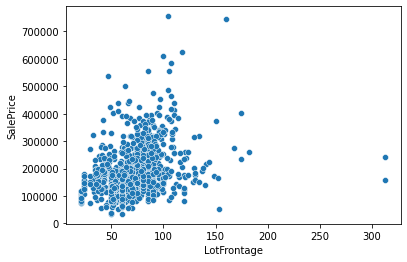

In [11]:
#let's first understand how different feature variables are related to the target variable (features vs saleprice) 
# by plotting and visualising them.
sns.scatterplot(housing_num['LotFrontage'], housing_num['SalePrice'])
plt.show()


1. Looking at the above plot, there is a cluster of values between 0-150 feet of LotFootage and 0-400000 dollars. Even though the relationship might not look strictly linear, we could draw a straight line through the points and explain the data.
2. We can also spot the outliers in the data - there are two data points at the extreme end of LotFrontage and two points which exceed the sale price of ```700,000$```


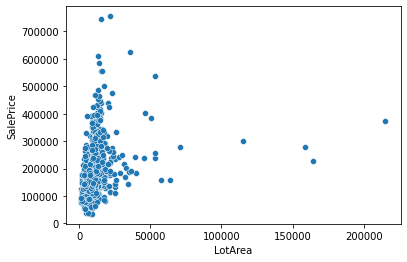

In [12]:
sns.scatterplot(housing_num['LotArea'], housing_num['SalePrice'])
plt.show()

1. The plot of ```LotArea``` vs ```SalePrice``` is different from what we observed in the first case. The distribution is more compact and for a given value of area, the price ranges from under 100000 to over 400000 dollars. We could say that the relationship is not strictly linear and there is perhaps a more complicated mapping of feature variable to the target variable.
2. We can also spot the outliers from this plot - the ones having lot area exceeding 150000 sq.ft and the ones exceeding sale price of 700000 dollars.

Alright, let's select some of the variables and visualise pairplots between them to get a better idea of relationship between 2 or more variables.

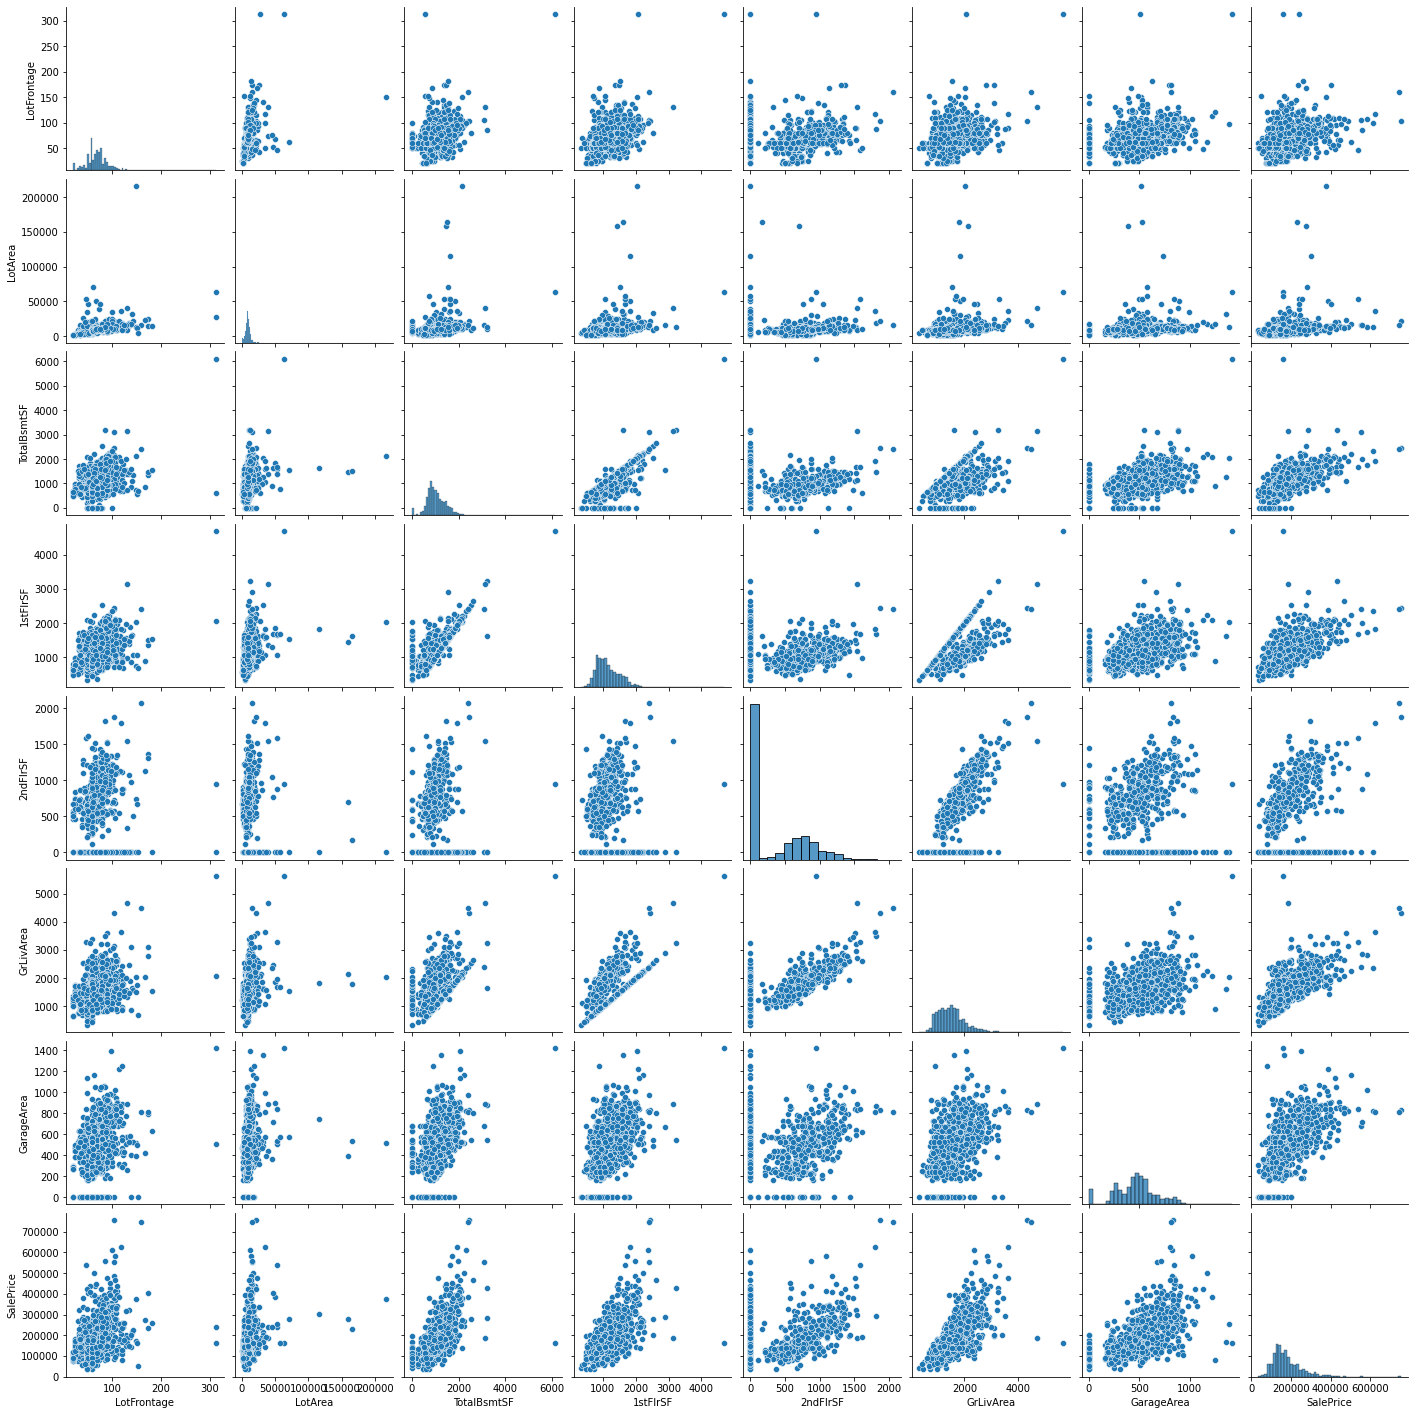

In [13]:
housing_num_filtered = housing_num[['LotFrontage', 'LotArea', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'GarageArea', 'SalePrice']]
sns.pairplot(housing_num_filtered)
plt.show()

The above is a set of pair-plots that show the relationship between each of the variables with one another. Let's particularly focus on the last row of plots which show us the relationship between ```SalePrice``` and other features.
1. When we look at total basement sq.feet vs price plot, we can observe that there are various data points which have the value 0 on the x-axis, meaning these are houses that do not have a basement.
2. The plot between second floor sq.feet vs price also has data points corresponding to 0 on the x-axis, meaning there are a number of houses that do not comprise of a second floor. This is observed with garage area vs price as well.
3. The plots of ```1stFlrSF```, ```2ndFlrSF``` and ```GrLivArea``` have somewhat of a linear increasing trend. As the area increases, we also see prices go up. Similar trends are observed with ```GarageArea``` vs ```SalePrice``` as well.

Let's take a look at the relationship between sale prices and the year in which the house was built/sold.

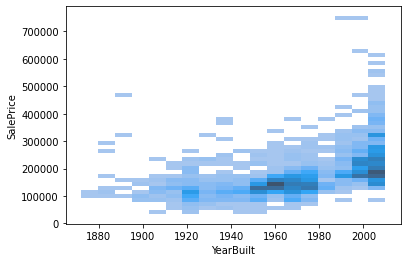

In [14]:
#convert YearBuilt and SalePrice to categorical variables


#plot price vs year built and year sold
sns.histplot(data=housing_num, x="YearBuilt", y="SalePrice")
plt.show()

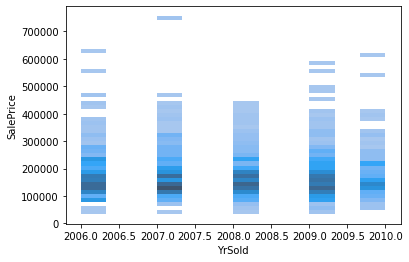

In [15]:
#plot price vs year built and year sold
sns.histplot(data=housing_num, x="YrSold", y="SalePrice")
plt.show()

Let's take a look at the categorical variables and some relevant plots for analyse them.

In [16]:
# all categorical (object) variables in the dataset
housing_cpy = housing.copy()
housing_cpy['Id'] = housing_cpy['Id'].astype(str)

housing_cat = housing_cpy.select_dtypes(include=['object'])
housing_cat.head()

,Id,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,1,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,NaN,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1,2,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,Gable,CompShg,MetalSd,MetalSd,None,TA,TA,CBlock,Gd,TA,Gd,ALQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,3,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Mn,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,4,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,Gable,CompShg,Wd Sdng,Wd Shng,None,TA,TA,BrkTil,TA,Gd,No,ALQ,Unf,GasA,Gd,Y,SBrkr,Gd,Typ,Gd,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
4,5,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Av,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal


As mentioned earlier, some of the variables are represented numerically even though they occupy certain discrete values to represent the data. Let's add them to the dataframe ```housing_cat``` and convert them to object types.

In [17]:
housing_num = housing.select_dtypes(include=['float64', 'int64'])
housing_num_filtered = housing_num[['MSSubClass', 'Id', 'OverallQual', 'OverallCond', 'MoSold', 'SalePrice']]

housing_cat['Id'] = housing_cat['Id'].astype('int64')
housing_cat_merge = pd.merge(housing_num_filtered, housing_cat, how='inner', on='Id')
housing_cat_merge.head()


,MSSubClass,Id,OverallQual,OverallCond,MoSold,SalePrice,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,60,1,7,5,2,208500,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,NaN,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1,20,2,6,8,5,181500,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,Gable,CompShg,MetalSd,MetalSd,None,TA,TA,CBlock,Gd,TA,Gd,ALQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,60,3,7,5,9,223500,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Mn,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,70,4,7,5,2,140000,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,Gable,CompShg,Wd Sdng,Wd Shng,None,TA,TA,BrkTil,TA,Gd,No,ALQ,Unf,GasA,Gd,Y,SBrkr,Gd,Typ,Gd,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
4,60,5,8,5,12,250000,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Av,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal


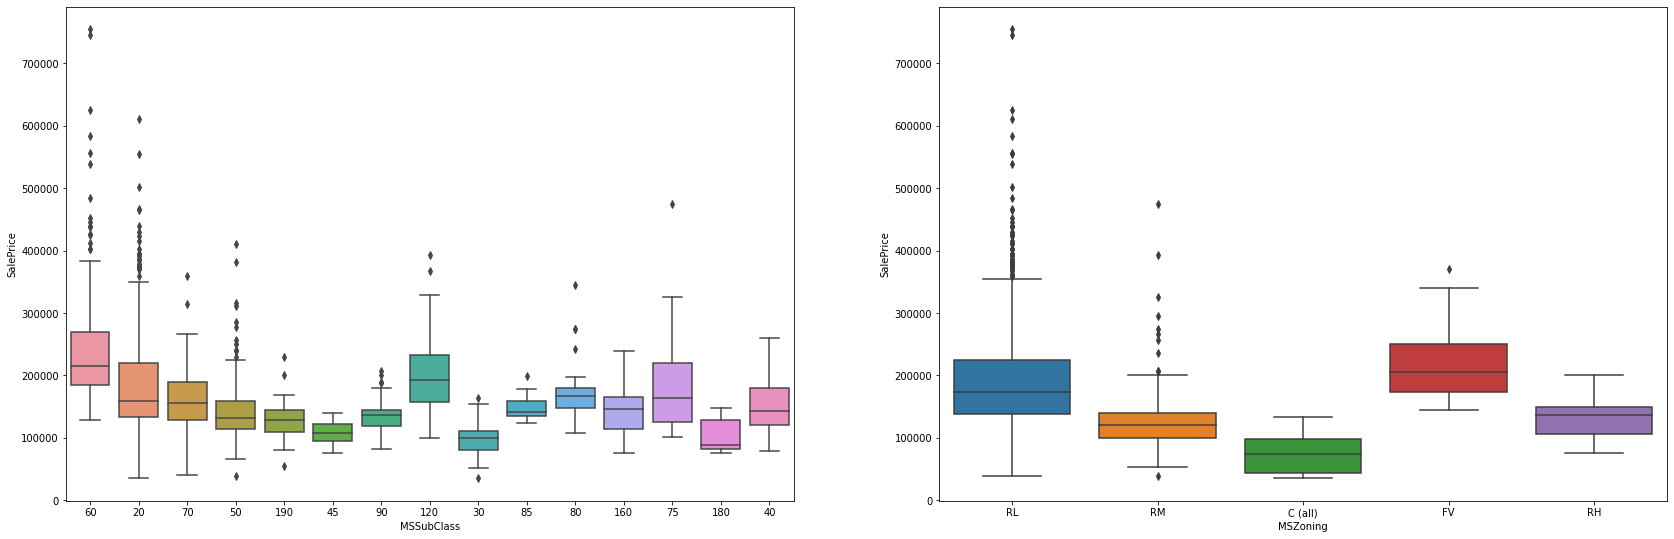

In [18]:
#convert numeric types to object types
housing_cat_merge['MSSubClass'] = housing_cat_merge['MSSubClass'].astype(str)

#let's plot type of dwelling involved in the sale vs prßice the house is sold using a box plot
plt.figure(figsize=(60, 20))
plt.subplot(2,4,1)
sns.boxplot(x = 'MSSubClass', y = 'SalePrice', data = housing_cat_merge)

#plot zoning type vs price 
plt.subplot(2,4,2)
sns.boxplot(x = 'MSZoning', y = 'SalePrice', data = housing_cat_merge)

plt.show()

1. category ```60``` (2-STORY 1946 & NEWER) seems to have higher median and quartile values of house price than all other categories, followed by ```120```(1-STORY PUD (Planned Unit Development) - 1946 & NEWER)   and ```75```(2-1/2 STORY ALL AGES). 
2. We can also look at how many outliers are there in our data, which are the black points that exceed Q4.
3. The right plot shows us zoning type vs sale price. ```FV```(Floating Village Residential) has the maximum median sale price followed by ```RL```(Residential Low Density). Commercial property seems to have the least median sale price.

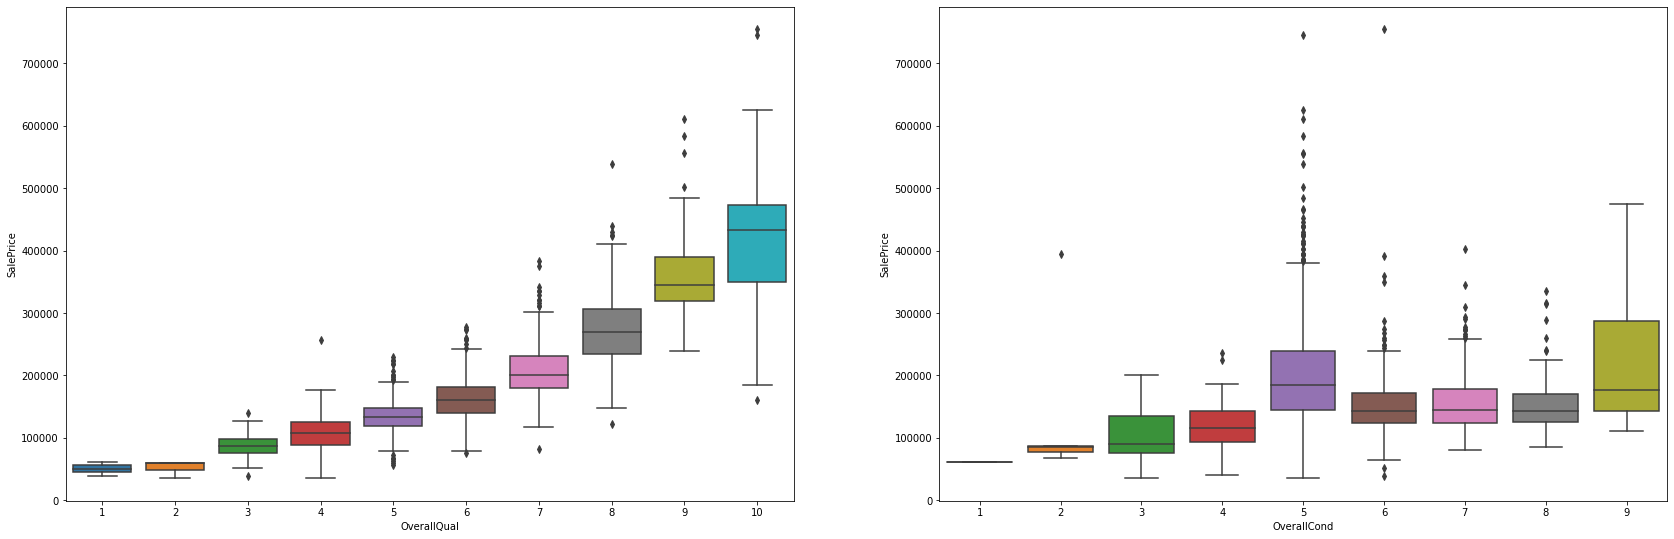

In [19]:
plt.figure(figsize=(60, 20))
plt.subplot(2,4,1)
sns.boxplot(x = 'OverallQual', y = 'SalePrice', data = housing_cat_merge)

plt.subplot(2,4,2)
sns.boxplot(x = 'OverallCond', y = 'SalePrice', data = housing_cat_merge)

plt.show()

The above plots show us the trend of overall quality and condition vs sale price. 
1. The left plot is like how we would expect it to be - i.e. higher the rating of house quality, higher the price of the house and we can see a linear increase in the values.
2. The plot on the right however, has steadily increasing median values till ```5``` after which the value drops and remains almost constant for categories ```6```,```7``` and ```8```. We see an increase in sale prices for category ```9```.

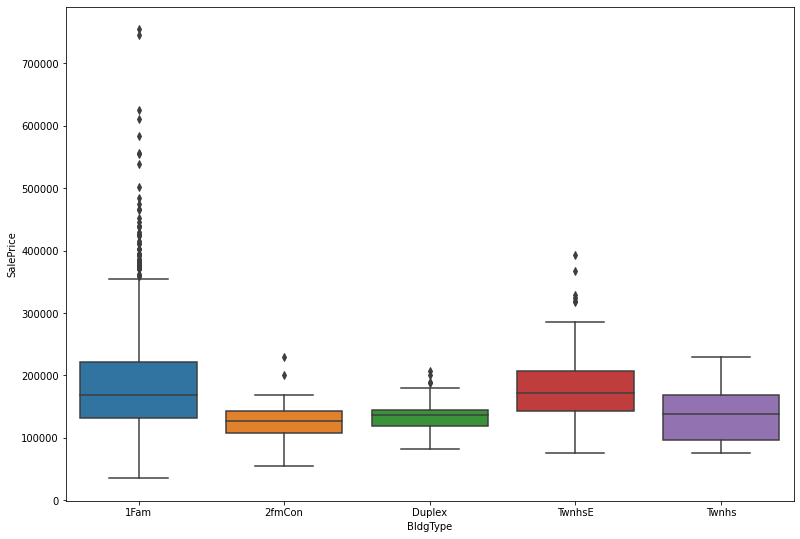

In [20]:
plt.figure(figsize=(60, 20))
plt.subplot(2,4,1)
sns.boxplot(x = 'BldgType', y = 'SalePrice', data = housing_cat_merge)

# plt.subplot(2,4,2)
# sns.boxplot(x = 'Neighborhood', y = 'SalePrice', data = housing_cat_merge)

plt.show()

In [21]:
#get numeric variables to see how they're correlated.
housing_num_fil = housing_num.drop(['MSSubClass','Id', 'OverallQual', 'OverallCond', 'MoSold'], axis=1)
housing_num_fil.head()

,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,YrSold,SalePrice
0,65.0,8450,2003,2003,196.0,706,0,150,856,856,854,0,1710,1,0,2,1,3,1,8,0,2003.0,2,548,0,61,0,0,0,0,0,2008,208500
1,80.0,9600,1976,1976,0.0,978,0,284,1262,1262,0,0,1262,0,1,2,0,3,1,6,1,1976.0,2,460,298,0,0,0,0,0,0,2007,181500
2,68.0,11250,2001,2002,162.0,486,0,434,920,920,866,0,1786,1,0,2,1,3,1,6,1,2001.0,2,608,0,42,0,0,0,0,0,2008,223500
3,60.0,9550,1915,1970,0.0,216,0,540,756,961,756,0,1717,1,0,1,0,3,1,7,1,1998.0,3,642,0,35,272,0,0,0,0,2006,140000
4,84.0,14260,2000,2000,350.0,655,0,490,1145,1145,1053,0,2198,1,0,2,1,4,1,9,1,2000.0,3,836,192,84,0,0,0,0,0,2008,250000


Let's now take a look at how the variables are correlated by plotting a heatmap.

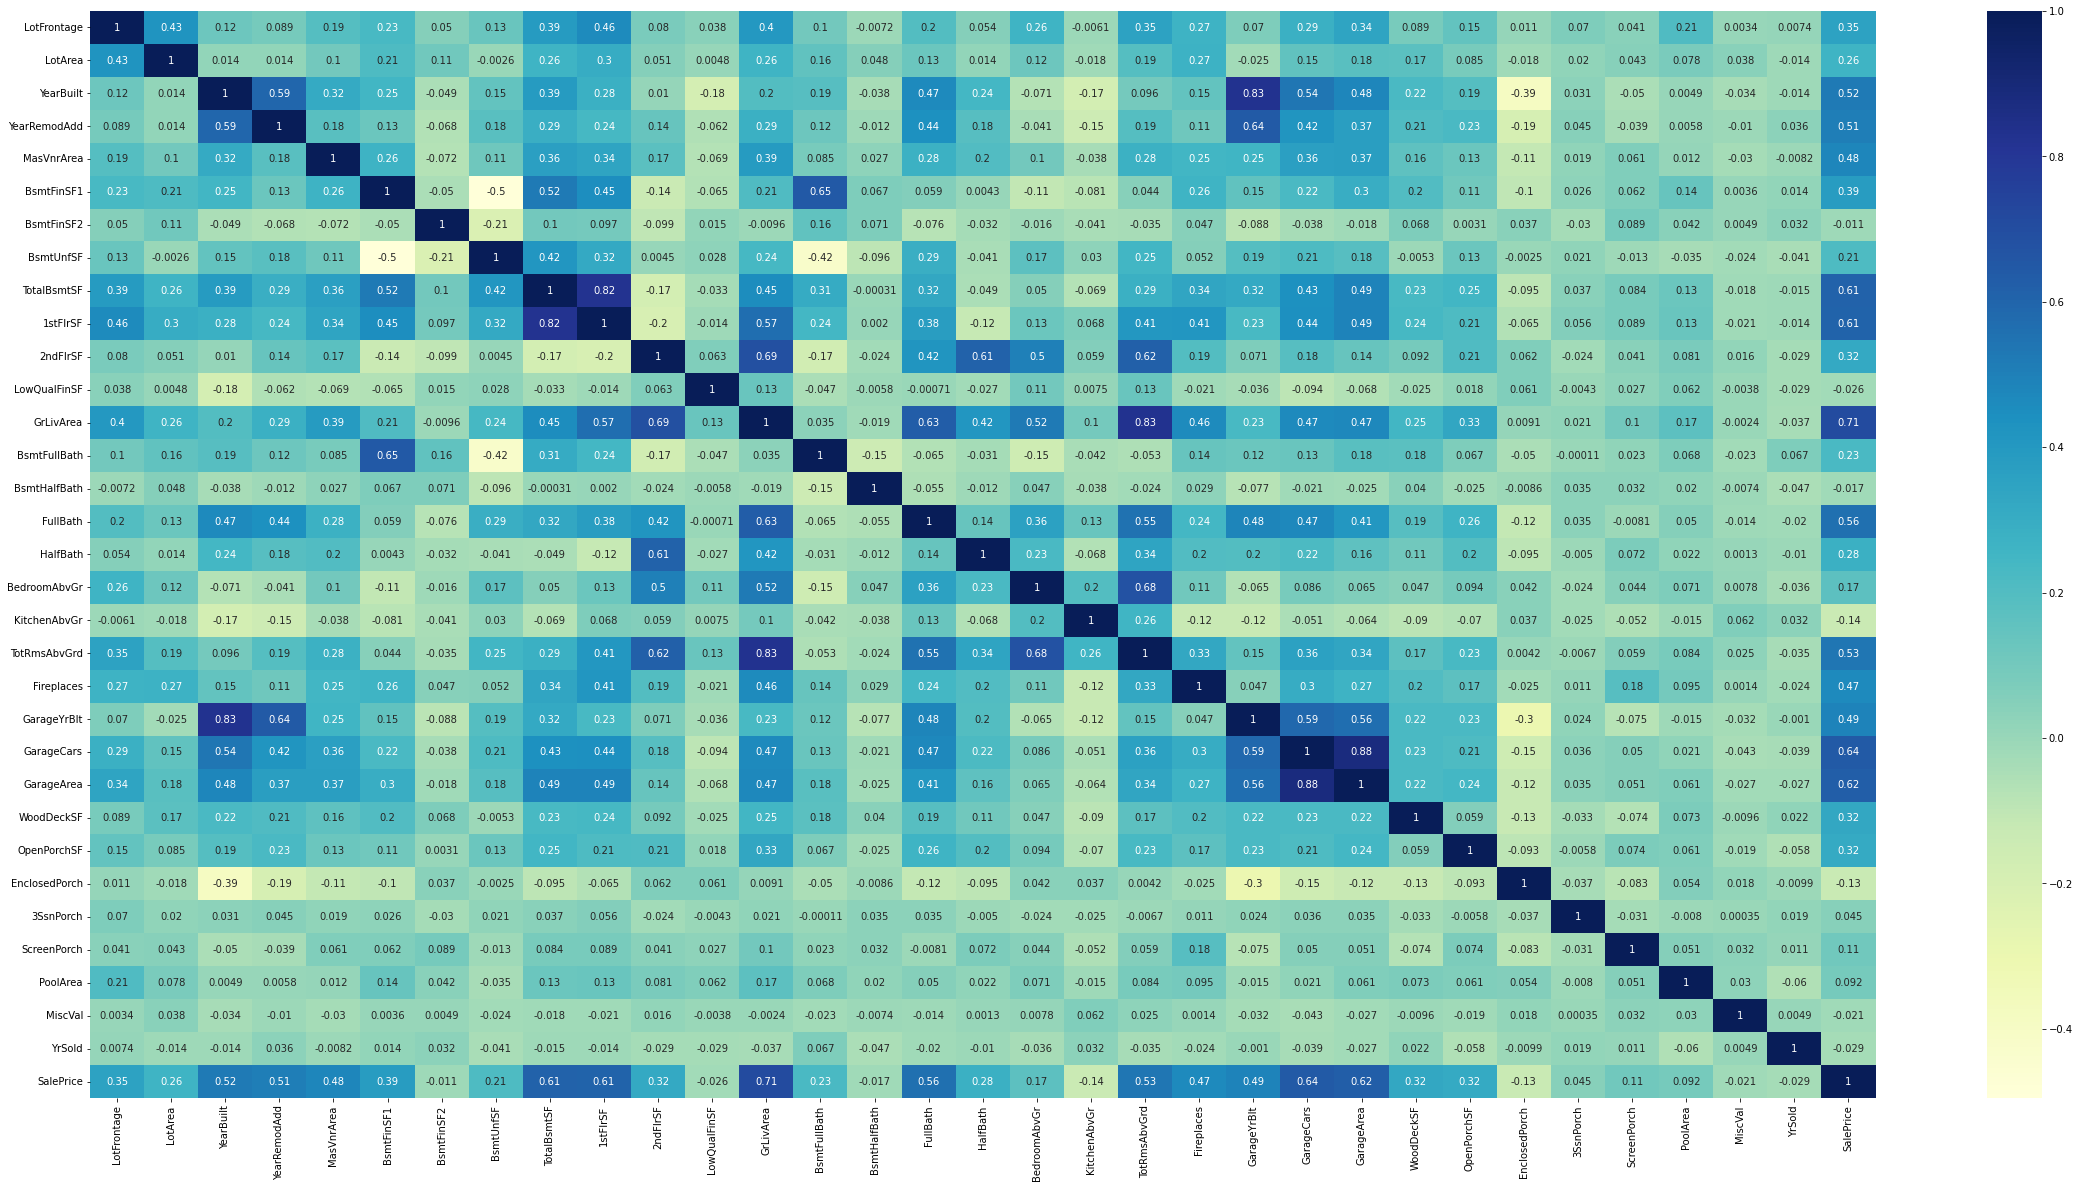

In [22]:
plt.figure(figsize = (40, 20))
sns.heatmap(housing_num_fil.corr(), annot = True, cmap="YlGnBu")
plt.show()

## 3. Data pre-processing and preparation

Earlier when we had explored the dataset, we observed some rows and columns having null values, categorical data being cast as numerical values and so on. Here, we will treat these issues present in the data before making it ready for modelling. Some of the steps performed include:
1. missing/null value imputation
2. dropping rows/columns if necessary
3. dummy variables for categorical variables
4. scaling of numeric variables

In [23]:
#lets check missing values in our data
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

Let's remove columns which have more than ```85%``` null values in them.

In [24]:
housing_na = housing.dropna(thresh=len(housing)*0.85 , axis=1)
housing_na.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 75 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   LotShape       1460 non-null   object 
 6   LandContour    1460 non-null   object 
 7   Utilities      1460 non-null   object 
 8   LotConfig      1460 non-null   object 
 9   LandSlope      1460 non-null   object 
 10  Neighborhood   1460 non-null   object 
 11  Condition1     1460 non-null   object 
 12  Condition2     1460 non-null   object 
 13  BldgType       1460 non-null   object 
 14  HouseStyle     1460 non-null   object 
 15  OverallQual    1460 non-null   int64  
 16  OverallCond    1460 non-null   int64  
 17  YearBuilt      1460 non-null   int64  
 18  YearRemo

We have 74 different columns now after dropping columns with null values greater than treshold.

In [25]:
#let's look at columns which still have some missing values and perform imputation depending on the nature of data.

#select columns which still have some missing values
df_null = housing_na.loc[:, housing_na.isnull().any()]      #this gives us the
df_null.head()


,MasVnrType,MasVnrArea,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Electrical,GarageType,GarageYrBlt,GarageFinish,GarageQual,GarageCond
0,BrkFace,196.0,Gd,TA,No,GLQ,Unf,SBrkr,Attchd,2003.0,RFn,TA,TA
1,None,0.0,Gd,TA,Gd,ALQ,Unf,SBrkr,Attchd,1976.0,RFn,TA,TA
2,BrkFace,162.0,Gd,TA,Mn,GLQ,Unf,SBrkr,Attchd,2001.0,RFn,TA,TA
3,None,0.0,TA,Gd,No,ALQ,Unf,SBrkr,Detchd,1998.0,Unf,TA,TA
4,BrkFace,350.0,Gd,TA,Av,GLQ,Unf,SBrkr,Attchd,2000.0,RFn,TA,TA


In [26]:
#let's fill the null values in all of the above columns
values = {"MasVnrType": df_null.mode(dropna=True)['MasVnrType'][0], 
            "MasVnrArea":df_null.median(skipna=True)['MasVnrArea'],
            "BsmtQual": df_null.mode(dropna=True)['BsmtQual'][0], 
            "BsmtCond":df_null.mode(dropna=True)['BsmtCond'][0],
            "BsmtExposure": df_null.mode(dropna=True)['BsmtExposure'][0], 
            "BsmtFinType1":df_null.mode(dropna=True)['BsmtFinType1'][0],
            "BsmtFinType2": df_null.mode(dropna=True)['BsmtFinType2'][0], 
            "Electrical":df_null.mode(dropna=True)['Electrical'][0],
            "GarageType": df_null.mode(dropna=True)['GarageType'][0], 
            "GarageYrBlt":df_null.median(skipna=True)['GarageYrBlt'],
            "GarageFinish": df_null.mode(dropna=True)['GarageFinish'][0], 
            "GarageQual":df_null.mode(dropna=True)['GarageQual'][0],
            "GarageCond":df_null.mode(dropna=True)['GarageCond'][0]
        }
housing_na = housing_na.fillna(value=values)
housing_na.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 75 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   LotShape       1460 non-null   object 
 6   LandContour    1460 non-null   object 
 7   Utilities      1460 non-null   object 
 8   LotConfig      1460 non-null   object 
 9   LandSlope      1460 non-null   object 
 10  Neighborhood   1460 non-null   object 
 11  Condition1     1460 non-null   object 
 12  Condition2     1460 non-null   object 
 13  BldgType       1460 non-null   object 
 14  HouseStyle     1460 non-null   object 
 15  OverallQual    1460 non-null   int64  
 16  OverallCond    1460 non-null   int64  
 17  YearBuilt      1460 non-null   int64  
 18  YearRemo

We now have non-null values in all the columns. Let's proceed to perform the other pre-processing steps as mentioned earlier.

#### Outlier treatment
Let's remove outliers in numerical data before modelling.

In [27]:
def remove_outliers(dtf, numl_list):
    for j in numl_list:
        Q1 = dtf[j].quantile(0.05)
        Q3 = dtf[j].quantile(0.95)
        IQR = Q3 - Q1       
        dtf = dtf[(dtf[j] >= Q1-2.5*IQR) & (dtf[j] <= Q3+2.5*IQR)]
    return dtf

In [28]:
housing_num = housing_na.select_dtypes(include = ['float64','int64'])
housing_num_list =list(housing_num.columns)
housing_na = remove_outliers(housing_na,housing_num_list)

#### Dummy variable creation

In [29]:
#lets split the data now into X(feature variables) and Y(target variable) before creating dummy variables
Y = np.log(housing_na['SalePrice'])
X = housing_na.drop(['Id', 'SalePrice'],axis=1)
print(X.shape, Y.shape)


(1285, 73) (1285,)


In [30]:
X_cpy = X.copy()

#lets convert the categorical variables that have been represented as numeric values
X_cpy['MSSubClass'] = X_cpy['MSSubClass'].astype(str)
X_cpy['OverallQual'] = X_cpy['OverallQual'].astype(str)
X_cpy['OverallCond'] = X_cpy['OverallCond'].astype(str)
X_cpy['MoSold'] = X_cpy['MoSold'].astype(str)

X_cat = X_cpy.select_dtypes(include=['object'])
X_cat.head()



,MSSubClass,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,MoSold,SaleType,SaleCondition
0,60,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,2,WD,Normal
1,20,RL,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,Gable,CompShg,MetalSd,MetalSd,None,TA,TA,CBlock,Gd,TA,Gd,ALQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,Attchd,RFn,TA,TA,Y,5,WD,Normal
2,60,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Mn,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,9,WD,Normal
3,70,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,Gable,CompShg,Wd Sdng,Wd Shng,None,TA,TA,BrkTil,TA,Gd,No,ALQ,Unf,GasA,Gd,Y,SBrkr,Gd,Typ,Detchd,Unf,TA,TA,Y,2,WD,Abnorml
4,60,RL,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Av,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,12,WD,Normal


In [31]:
#changing the category name of MSSubClass based on data dict

ms_subclass_dic = { 
        "20":	"1-STORY 1946 & NEWER ALL STYLES",
        "30":	"1-STORY 1945 & OLDER",
        "40":	"1-STORY W/FINISHED ATTIC ALL AGES",
        "45":	"1-1/2 STORY-UNFINISHED ALL AGES",
        "50":	"1-1/2 STORY FINISHED ALL AGES",
        "60":	"2-STORY 1946 & NEWER",
        "70":	"2-STORY 1945 & OLDER",
        "75":	"2-1/2 STORY ALL AGES",
        "80":	"SPLIT OR MULTI-LEVEL",
        "85":	"SPLIT FOYER",
        "90":	"DUPLEX-ALL STYLES AND AGES",
       "120":	"1-STORY PUD-1946 & NEWER",
       "150":	"1-1/2 STORY PUD - ALL AGES",
       "160":	"2-STORY PUD-1946 & NEWER",
       "180":	"PUD-MULTILEVEL-INCL SPLIT LEV/FOYER",
       "190":	"2 FAMILY CONVERSION-ALL STYLES AND AGES"
    }

X_cat['MSSubClass'] = X_cat['MSSubClass'].map(ms_subclass_dic)
X_cat.head()



,MSSubClass,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,MoSold,SaleType,SaleCondition
0,2-STORY 1946 & NEWER,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,2,WD,Normal
1,1-STORY 1946 & NEWER ALL STYLES,RL,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,Gable,CompShg,MetalSd,MetalSd,None,TA,TA,CBlock,Gd,TA,Gd,ALQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,Attchd,RFn,TA,TA,Y,5,WD,Normal
2,2-STORY 1946 & NEWER,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Mn,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,9,WD,Normal
3,2-STORY 1945 & OLDER,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,Gable,CompShg,Wd Sdng,Wd Shng,None,TA,TA,BrkTil,TA,Gd,No,ALQ,Unf,GasA,Gd,Y,SBrkr,Gd,Typ,Detchd,Unf,TA,TA,Y,2,WD,Abnorml
4,2-STORY 1946 & NEWER,RL,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Av,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,12,WD,Normal


In [32]:
# convert into dummies - one hot encoding
X_cat_dummies = pd.get_dummies(X_cat, drop_first=True)
X_cat_dummies.head()

,MSSubClass_1-1/2 STORY-UNFINISHED ALL AGES,MSSubClass_1-STORY 1945 & OLDER,MSSubClass_1-STORY 1946 & NEWER ALL STYLES,MSSubClass_1-STORY PUD-1946 & NEWER,MSSubClass_1-STORY W/FINISHED ATTIC ALL AGES,MSSubClass_2 FAMILY CONVERSION-ALL STYLES AND AGES,MSSubClass_2-1/2 STORY ALL AGES,MSSubClass_2-STORY 1945 & OLDER,MSSubClass_2-STORY 1946 & NEWER,MSSubClass_2-STORY PUD-1946 & NEWER,MSSubClass_DUPLEX-ALL STYLES AND AGES,MSSubClass_PUD-MULTILEVEL-INCL SPLIT LEV/FOYER,MSSubClass_SPLIT FOYER,MSSubClass_SPLIT OR MULTI-LEVEL,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_NoSeWa,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRNn,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,OverallQual_10,OverallQual_2,OverallQual_3,OverallQual_4,OverallQual_5,OverallQual_6,OverallQual_7,OverallQual_8,OverallQual_9,OverallCond_2,OverallCond_3,OverallCond_4,OverallCond_5,OverallCond_6,OverallCond_7,OverallCond_8,OverallCond_9,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_Membran,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Fa,ExterCond_Gd,ExterCond_TA,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,BsmtCond_Gd,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_Y,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Fa,GarageQual_Gd,GarageQual_Po,GarageQual_TA,GarageCond_Fa,GarageCond_Gd,GarageCond_Po,GarageCond_TA,PavedDrive_P,PavedDrive_Y,MoSold_10,MoSold_11,MoSold_12,MoSold_2,MoSold_3,MoSold_4,MoSold_5,MoSold_6,MoSold_7,MoSold_8,MoSold_9,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondit

In [33]:
# drop categorical variables 
X = X.drop(list(X_cat.columns), axis=1)
X.head()

,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,YrSold
0,8450,2003,2003,196.0,706,0,150,856,856,854,0,1710,1,0,2,1,3,1,8,0,2003.0,2,548,0,61,0,0,0,0,0,2008
1,9600,1976,1976,0.0,978,0,284,1262,1262,0,0,1262,0,1,2,0,3,1,6,1,1976.0,2,460,298,0,0,0,0,0,0,2007
2,11250,2001,2002,162.0,486,0,434,920,920,866,0,1786,1,0,2,1,3,1,6,1,2001.0,2,608,0,42,0,0,0,0,0,2008
3,9550,1915,1970,0.0,216,0,540,756,961,756,0,1717,1,0,1,0,3,1,7,1,1998.0,3,642,0,35,272,0,0,0,0,2006
4,14260,2000,2000,350.0,655,0,490,1145,1145,1053,0,2198,1,0,2,1,4,1,9,1,2000.0,3,836,192,84,0,0,0,0,0,2008


In [34]:
# concat dummy variables with X
X = pd.concat([X, X_cat_dummies], axis=1)
X.head()

,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,YrSold,MSSubClass_1-1/2 STORY-UNFINISHED ALL AGES,MSSubClass_1-STORY 1945 & OLDER,MSSubClass_1-STORY 1946 & NEWER ALL STYLES,MSSubClass_1-STORY PUD-1946 & NEWER,MSSubClass_1-STORY W/FINISHED ATTIC ALL AGES,MSSubClass_2 FAMILY CONVERSION-ALL STYLES AND AGES,MSSubClass_2-1/2 STORY ALL AGES,MSSubClass_2-STORY 1945 & OLDER,MSSubClass_2-STORY 1946 & NEWER,MSSubClass_2-STORY PUD-1946 & NEWER,MSSubClass_DUPLEX-ALL STYLES AND AGES,MSSubClass_PUD-MULTILEVEL-INCL SPLIT LEV/FOYER,MSSubClass_SPLIT FOYER,MSSubClass_SPLIT OR MULTI-LEVEL,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_NoSeWa,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRNn,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,OverallQual_10,OverallQual_2,OverallQual_3,OverallQual_4,OverallQual_5,OverallQual_6,OverallQual_7,OverallQual_8,OverallQual_9,OverallCond_2,OverallCond_3,OverallCond_4,OverallCond_5,OverallCond_6,OverallCond_7,OverallCond_8,OverallCond_9,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_Membran,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Fa,ExterCond_Gd,ExterCond_TA,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,BsmtCond_Gd,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_Y,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Fa,GarageQual_Gd,GarageQual_Po,GarageQual_TA,GarageCond_Fa,GarageCond_Gd,GarageCond_Po,GarageCo

#### Scaling
Now that we have created dummy variables, let's move to the step of scaling of numerical values using a StandardScaler.

In [35]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_num = X.select_dtypes(include = ['float64','int64'])
X_num_list =list(X_num.columns)

X[X_num_list] = scaler.fit_transform(X[X_num_list])
X.head()


,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,YrSold,MSSubClass_1-1/2 STORY-UNFINISHED ALL AGES,MSSubClass_1-STORY 1945 & OLDER,MSSubClass_1-STORY 1946 & NEWER ALL STYLES,MSSubClass_1-STORY PUD-1946 & NEWER,MSSubClass_1-STORY W/FINISHED ATTIC ALL AGES,MSSubClass_2 FAMILY CONVERSION-ALL STYLES AND AGES,MSSubClass_2-1/2 STORY ALL AGES,MSSubClass_2-STORY 1945 & OLDER,MSSubClass_2-STORY 1946 & NEWER,MSSubClass_2-STORY PUD-1946 & NEWER,MSSubClass_DUPLEX-ALL STYLES AND AGES,MSSubClass_PUD-MULTILEVEL-INCL SPLIT LEV/FOYER,MSSubClass_SPLIT FOYER,MSSubClass_SPLIT OR MULTI-LEVEL,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_NoSeWa,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRNn,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,OverallQual_10,OverallQual_2,OverallQual_3,OverallQual_4,OverallQual_5,OverallQual_6,OverallQual_7,OverallQual_8,OverallQual_9,OverallCond_2,OverallCond_3,OverallCond_4,OverallCond_5,OverallCond_6,OverallCond_7,OverallCond_8,OverallCond_9,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_Membran,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Fa,ExterCond_Gd,ExterCond_TA,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,BsmtCond_Gd,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_Y,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Fa,GarageQual_Gd,GarageQual_Po,GarageQual_TA,GarageCond_Fa,GarageCond_Gd,GarageCond_Po,GarageCo

Now that we have scaled all of our values, let's go back to seeing correlation between variables as some of the variables can be dropped based on their correlation with other variables.

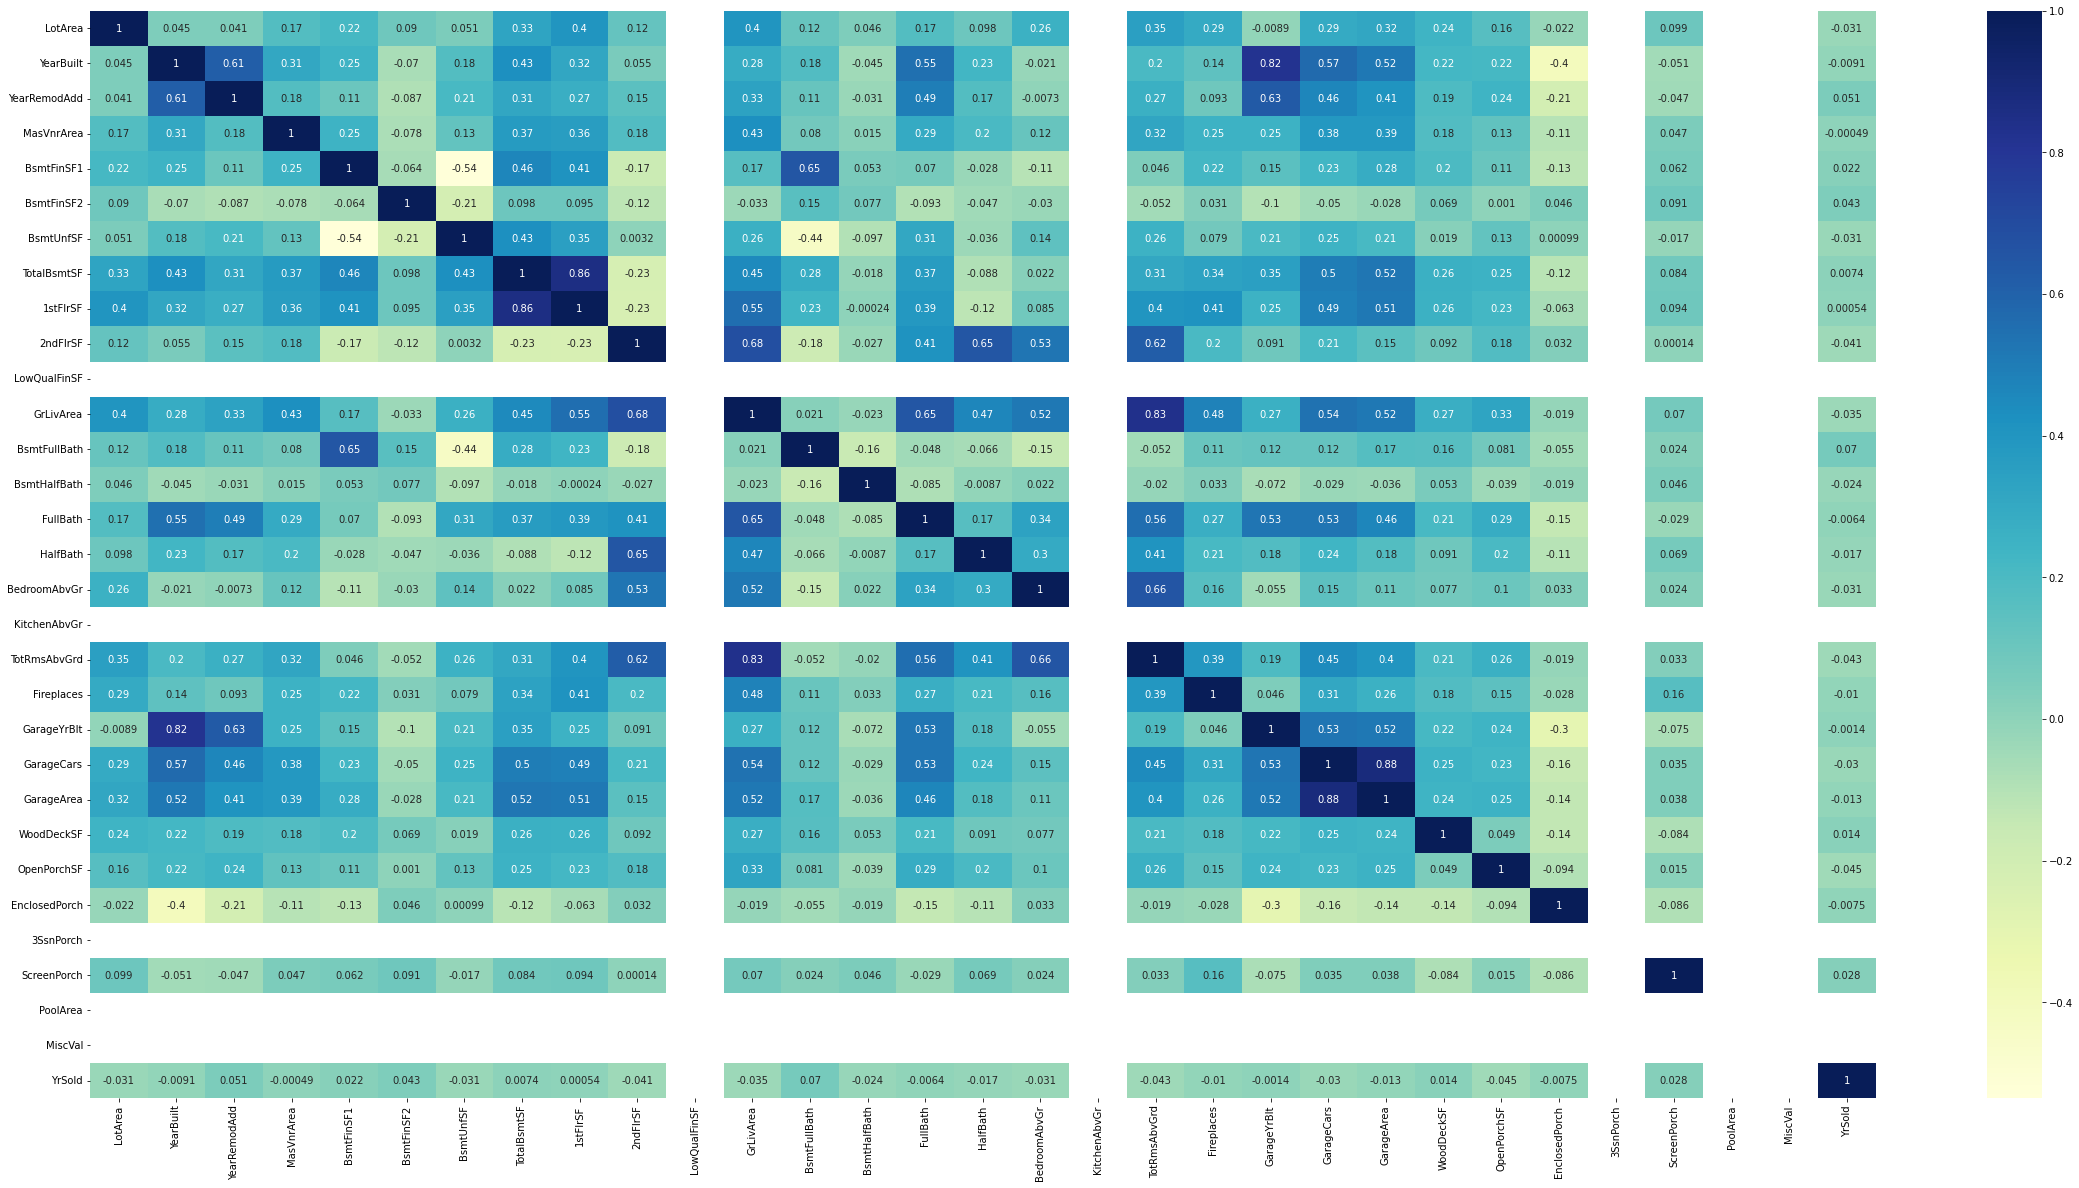

In [36]:
plt.figure(figsize = (40, 20))
sns.heatmap(X_num.corr(), annot = True, cmap="YlGnBu")
plt.show()

Looking at the above heatmap, we can observe this:
1. There is some correlation between the independent variables as well. We shall identify them and drop some of it before modelling as it will help us reduce the number of features in our model, thereby preventing overfitting.

In [37]:
# housing_num_fil = housing_num_fil.drop(['SalePrice'],axis=1)
corr_mat = X_num.corr().abs()
corr_mat.head()

,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,YrSold
LotArea,1.000000,0.045179,0.040670,0.174323,0.219919,0.089991,0.050593,0.326434,0.402342,0.119137,NaN,0.404259,0.117692,0.046082,0.172721,0.097870,0.261306,NaN,0.347686,0.293033,0.008880,0.293420,0.315135,0.239352,0.163210,0.022480,NaN,0.099286,NaN,NaN,0.030790
YearBuilt,0.045179,1.000000,0.614729,0.305594,0.245139,0.069546,0.177200,0.427271,0.316250,0.055307,NaN,0.284843,0.179687,0.045184,0.546933,0.226925,0.021328,NaN,0.202423,0.140123,0.815078,0.570348,0.517065,0.222931,0.216701,0.401198,NaN,0.050902,NaN,NaN,0.009061
YearRemodAdd,0.040670,0.614729,1.000000,0.176117,0.105128,0.086784,0.214121,0.310591,0.272949,0.151501,NaN,0.334928,0.113525,0.031103,0.493373,0.173328,0.007283,NaN,0.266879,0.092826,0.630169,0.461321,0.407731,0.192722,0.241896,0.211401,NaN,0.047242,NaN,NaN,0.050536
MasVnrArea,0.174323,0.305594,0.176117,1.000000,0.246200,0.077960,0.128844,0.372489,0.358722,0.183938,NaN,0.427153,0.079554,0.015178,0.293127,0.203576,0.115771,NaN,0.322054,0.252307,0.253177,0.384191,0.387287,0.183322,0.130858,0.105819,NaN,0.046523,NaN,NaN,0.000495
BsmtFinSF1,0.219919,0.245139,0.105128,0.246200,1.000000,0.063786,0.535381,0.463394,0.414811,0.169730,NaN,0.165620,0.650648,0.053289,0.069562,0.028193,0.106962,NaN,0.046082,0.223221,0.154282,0.230660,0.282684,0.201100,0.108637,0.125854,NaN,0.061890,NaN,NaN,0.022198


In [38]:
#get the upper traingle as the matrix is mirror image about the diagonal
upper_tri = corr_mat.where(np.triu(np.ones(corr_mat.shape),k=1).astype(np.bool))
print(upper_tri)

               LotArea  YearBuilt  YearRemodAdd  MasVnrArea  BsmtFinSF1  \
LotArea            NaN   0.045179      0.040670    0.174323    0.219919   
YearBuilt          NaN        NaN      0.614729    0.305594    0.245139   
YearRemodAdd       NaN        NaN           NaN    0.176117    0.105128   
MasVnrArea         NaN        NaN           NaN         NaN    0.246200   
BsmtFinSF1         NaN        NaN           NaN         NaN         NaN   
BsmtFinSF2         NaN        NaN           NaN         NaN         NaN   
BsmtUnfSF          NaN        NaN           NaN         NaN         NaN   
TotalBsmtSF        NaN        NaN           NaN         NaN         NaN   
1stFlrSF           NaN        NaN           NaN         NaN         NaN   
2ndFlrSF           NaN        NaN           NaN         NaN         NaN   
LowQualFinSF       NaN        NaN           NaN         NaN         NaN   
GrLivArea          NaN        NaN           NaN         NaN         NaN   
BsmtFullBath       NaN   

In [39]:
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.75)]
print(to_drop)

['1stFlrSF', 'TotRmsAbvGrd', 'GarageYrBlt', 'GarageArea']


In [40]:
X = X.drop(to_drop,axis=1)
X.head()

,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,Fireplaces,GarageCars,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,YrSold,MSSubClass_1-1/2 STORY-UNFINISHED ALL AGES,MSSubClass_1-STORY 1945 & OLDER,MSSubClass_1-STORY 1946 & NEWER ALL STYLES,MSSubClass_1-STORY PUD-1946 & NEWER,MSSubClass_1-STORY W/FINISHED ATTIC ALL AGES,MSSubClass_2 FAMILY CONVERSION-ALL STYLES AND AGES,MSSubClass_2-1/2 STORY ALL AGES,MSSubClass_2-STORY 1945 & OLDER,MSSubClass_2-STORY 1946 & NEWER,MSSubClass_2-STORY PUD-1946 & NEWER,MSSubClass_DUPLEX-ALL STYLES AND AGES,MSSubClass_PUD-MULTILEVEL-INCL SPLIT LEV/FOYER,MSSubClass_SPLIT FOYER,MSSubClass_SPLIT OR MULTI-LEVEL,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_NoSeWa,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRNn,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,OverallQual_10,OverallQual_2,OverallQual_3,OverallQual_4,OverallQual_5,OverallQual_6,OverallQual_7,OverallQual_8,OverallQual_9,OverallCond_2,OverallCond_3,OverallCond_4,OverallCond_5,OverallCond_6,OverallCond_7,OverallCond_8,OverallCond_9,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_Membran,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Fa,ExterCond_Gd,ExterCond_TA,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,BsmtCond_Gd,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_Y,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Fa,GarageQual_Gd,GarageQual_Po,GarageQual_TA,GarageCond_Fa,GarageCond_Gd,GarageCond_Po,GarageCond_TA,PavedDrive_P,PavedDrive_Y,MoSold_10,MoS

## 4. Modelling

Let's dive into building a model using linear regression, first with a simple LinearRegression combined with RFE and evaluate it using metrics like RMSE and r2 scores. We will follow that up with using ridge and lasso regression and hyper parameter tuning to see how our model performs.

In [41]:
from sklearn.feature_selection import RFE
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

#sanity check
print(X.shape, Y.shape)

#we'll use the sklearn LinearRegression estimator for RFE 
lm = LinearRegression()
rfe = RFE(lm, n_features_to_select=40)             # running RFE
rfe = rfe.fit(X, Y)

(1285, 257) (1285,)


In [42]:
#list of features from rfe
# list(zip(X.columns,rfe.support_,rfe.ranking_))

In [43]:
col = X.columns[rfe.support_]
col

Index(['TotalBsmtSF', 'GrLivArea', 'MSSubClass_2-1/2 STORY ALL AGES',
       'MSSubClass_2-STORY PUD-1946 & NEWER', 'MSSubClass_SPLIT FOYER',
       'MSZoning_FV', 'MSZoning_RH', 'MSZoning_RL', 'MSZoning_RM',
       'LandSlope_Sev', 'Neighborhood_Crawfor', 'Condition2_PosN',
       'OverallQual_10', 'OverallQual_2', 'OverallQual_3', 'OverallQual_4',
       'OverallQual_5', 'OverallQual_6', 'OverallQual_7', 'OverallQual_8',
       'OverallQual_9', 'OverallCond_2', 'OverallCond_3', 'OverallCond_4',
       'RoofMatl_Membran', 'Exterior1st_CBlock', 'Exterior2nd_CBlock',
       'Foundation_Stone', 'Heating_Grav', 'Heating_Wall', 'Electrical_FuseP',
       'Electrical_Mix', 'Functional_Maj2', 'Functional_Mod', 'Functional_Sev',
       'GarageType_CarPort', 'GarageQual_Fa', 'GarageCond_Fa', 'GarageCond_Gd',
       'GarageCond_TA'],
      dtype='object')

In [44]:
# Creating X_test dataframe with RFE selected variables
X_train_rfe = X[col]
# X_train_rfe.head()

In [45]:
#fit the new dataset 
X_train_lm = sm.add_constant(X_train_rfe)
lr = sm.OLS(Y, X_train_lm).fit()

In [46]:
# Print a summary of the linear regression model obtained
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.873
Method:                 Least Squares   F-statistic:                     227.5
Date:                Tue, 12 Jul 2022   Prob (F-statistic):               0.00
Time:                        15:13:49   Log-Likelihood:                 704.15
No. Observations:                1285   AIC:                            -1328.
Df Residuals:                    1245   BIC:                            -1122.
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                  10.8436      0.143     75.584      0.000      10.562      11.125
TotalBsmtSF                             0.0820      0.005     15.443      0.000       0.072       0.092
GrLivArea                               0.1494      0.006     26.875      0.000       0.139       0.160
MSSubClass_2-1/2 STORY ALL AGES        -0.1000      0.049     -2.044      0.041      -0.196      -0.004
MSSubClass_2-STORY PUD-1946 & NEWER    -0.1006      0.021     -4.816      0.000      -0.142      -0.060
MSSubClass_SPLIT FOYER                  0.0754      0.033      2.258      0.024       0.010       0.141
MSZoning_FV                             0.7218      0.069     10.508      0.000       0.587       0.857
MSZoning_RH                             0.5087      0.077      6.628      0.000       0.358       0.659
MSZoning_RL                             0.6337      0.066      9.632      0.000       0.505       0.763
MSZoning_RM                             0.5133      0.066      7.787      0.000       0.384       0.643
LandSlope_Sev                          -0.0888      0.061     -1.449      0.148      -0.209       0.031
Neighborhood_Crawfor                    0.0869      0.023      3.839      0.000       0.043       0.131
Condition2_PosN                        -0.8904      0.109     -8.196      0.000      -1.104      -0.677
OverallQual_10                          1.1237      0.118      9.505      0.000       0.892       1.356
OverallQual_2                           0.4145      0.137      3.026      0.003       0.146       0.683
OverallQual_3                           0.3795      0.115      3.312      0.001       0.155       0.604
OverallQual_4                           0.4780      0.108      4.419      0.000       0.266       0.690
OverallQual_5                           0.5608      0.107      5.220      0.000       0.350       0.772
OverallQual_6                           0.6544      0.108      6.057      0.000       0.442       0.866
OverallQual_7                           0.7740      0.109      7.131      0.000       0.561       0.987
OverallQual_8                           0.9002      0.110      8.209      0.000       0.685       1.115
OverallQual_9                           1.0916      0.112      9.740      0.000       0.872       1.311
OverallCond_2                           0.1409      0.144      0.980      0.327      -0.141       0.423
OverallCond_3                          -0.2661      0.035     -7.694      0.000      -0.334      -0.198
OverallCond_4                          -0.1205      0.024     -4.964      0.000      -0.168      -0.073
RoofMatl_Membran                        0.5140      0.166      3.094      0.002       0.188       0.840
Exterior1st_CBlock                     -0.1096      0.072     -1.53

In [47]:
#drop the const column before calculating VIF
X_train_dropped = X_train_lm.drop(['const'], axis=1)

In [48]:
# Calculate the VIFs for the new model
vif = pd.DataFrame()
X_new = X_train_dropped
vif['Features'] = X_new.columns
vif['VIF'] = [variance_inflation_factor(X_new.values, i) for i in range(X_new.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
26,Exterior2nd_CBlock,inf
25,Exterior1st_CBlock,inf
39,GarageCond_TA,235.92
7,MSZoning_RL,175.62
17,OverallQual_6,83.09
16,OverallQual_5,81.97
18,OverallQual_7,74.01
19,OverallQual_8,42.09
8,MSZoning_RM,32.27
15,OverallQual_4,23.76


Some of our features have a VIF of ```inf```, which means that there is high levels of correlation. Let's drop the columns that have infinite VIF and retrain our model again.

In [49]:
cols_to_drop = vif['Features'].where(vif['VIF'] == float('inf'))
cols_to_drop.dropna(inplace=True)
cols_to_drop = cols_to_drop.to_list()
cols_to_drop = cols_to_drop[0]  #let's remove columns one by one and re-check VIF
print(cols_to_drop)

Exterior2nd_CBlock


In [50]:
X_train_rfe = X_train_rfe.drop(columns=cols_to_drop)
# X_train_rfe.head()

In [51]:
#let's fit the model again with new set of features
X_train_lm = sm.add_constant(X_train_rfe)
lr = sm.OLS(Y, X_train_lm).fit()

In [52]:
#Let's see the summary of the new model
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.873
Method:                 Least Squares   F-statistic:                     227.5
Date:                Tue, 12 Jul 2022   Prob (F-statistic):               0.00
Time:                        15:13:50   Log-Likelihood:                 704.15
No. Observations:                1285   AIC:                            -1328.
Df Residuals:                    1245   BIC:                            -1122.
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                  10.8436      0.143     75.584      0.000      10.562      11.125
TotalBsmtSF                             0.0820      0.005     15.443      0.000       0.072       0.092
GrLivArea                               0.1494      0.006     26.875      0.000       0.139       0.160
MSSubClass_2-1/2 STORY ALL AGES        -0.1000      0.049     -2.044      0.041      -0.196      -0.004
MSSubClass_2-STORY PUD-1946 & NEWER    -0.1006      0.021     -4.816      0.000      -0.142      -0.060
MSSubClass_SPLIT FOYER                  0.0754      0.033      2.258      0.024       0.010       0.141
MSZoning_FV                             0.7218      0.069     10.508      0.000       0.587       0.857
MSZoning_RH                             0.5087      0.077      6.628      0.000       0.358       0.659
MSZoning_RL                             0.6337      0.066      9.632      0.000       0.505       0.763
MSZoning_RM                             0.5133      0.066      7.787      0.000       0.384       0.643
LandSlope_Sev                          -0.0888      0.061     -1.449      0.148      -0.209       0.031
Neighborhood_Crawfor                    0.0869      0.023      3.839      0.000       0.043       0.131
Condition2_PosN                        -0.8904      0.109     -8.196      0.000      -1.104      -0.677
OverallQual_10                          1.1237      0.118      9.505      0.000       0.892       1.356
OverallQual_2                           0.4145      0.137      3.026      0.003       0.146       0.683
OverallQual_3                           0.3795      0.115      3.312      0.001       0.155       0.604
OverallQual_4                           0.4780      0.108      4.419      0.000       0.266       0.690
OverallQual_5                           0.5608      0.107      5.220      0.000       0.350       0.772
OverallQual_6                           0.6544      0.108      6.057      0.000       0.442       0.866
OverallQual_7                           0.7740      0.109      7.131      0.000       0.561       0.987
OverallQual_8                           0.9002      0.110      8.209      0.000       0.685       1.115
OverallQual_9                           1.0916      0.112      9.740      0.000       0.872       1.311
OverallCond_2                           0.1409      0.144      0.980      0.327      -0.141       0.423
OverallCond_3                          -0.2661      0.035     -7.694      0.000      -0.334      -0.198
OverallCond_4                          -0.1205      0.024     -4.964      0.000      -0.168      -0.073
RoofMatl_Membran                        0.5140      0.166      3.094      0.002       0.188       0.840
Exterior1st_CBlock                     -0.2191      0.143     -1.53

In [53]:
#drop the const column before calculating VIF
X_train_dropped = X_train_lm.drop(['const'], axis=1)

In [54]:
vif = pd.DataFrame()
X_new = X_train_dropped
vif['Features'] = X_new.columns
vif['VIF'] = [variance_inflation_factor(X_new.values, i) for i in range(X_new.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
38,GarageCond_TA,235.92
7,MSZoning_RL,175.62
17,OverallQual_6,83.09
16,OverallQual_5,81.97
18,OverallQual_7,74.01
19,OverallQual_8,42.09
8,MSZoning_RM,32.27
15,OverallQual_4,23.76
20,OverallQual_9,12.22
5,MSZoning_FV,11.70


There are still features which have a high VIF. Let's remove them and repeat the same process again.

In [55]:
cols_to_drop = vif['Features'].where(vif['VIF'] > float(5))
cols_to_drop.dropna(inplace=True)
cols_to_drop = cols_to_drop.to_list()
cols_to_drop = cols_to_drop[0]
print(cols_to_drop)

GarageCond_TA


In [56]:
X_train_rfe = X_train_rfe.drop(columns=cols_to_drop)
# X_train_rfe.head()

In [57]:
#let's fit the model again with new set of features

# Add a constant
X_train_lm = sm.add_constant(X_train_rfe)

# Create a first fitted model
lr = sm.OLS(Y, X_train_lm).fit()

In [58]:
#Let's see the summary of the new model
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.873
Method:                 Least Squares   F-statistic:                     233.3
Date:                Tue, 12 Jul 2022   Prob (F-statistic):               0.00
Time:                        15:13:51   Log-Likelihood:                 703.21
No. Observations:                1285   AIC:                            -1328.
Df Residuals:                    1246   BIC:                            -1127.
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                  10.7528      0.127     84.822      0.000      10.504      11.002
TotalBsmtSF                             0.0819      0.005     15.425      0.000       0.071       0.092
GrLivArea                               0.1495      0.006     26.879      0.000       0.139       0.160
MSSubClass_2-1/2 STORY ALL AGES        -0.1006      0.049     -2.056      0.040      -0.197      -0.005
MSSubClass_2-STORY PUD-1946 & NEWER    -0.1006      0.021     -4.818      0.000      -0.142      -0.060
MSSubClass_SPLIT FOYER                  0.0751      0.033      2.248      0.025       0.010       0.141
MSZoning_FV                             0.7185      0.069     10.462      0.000       0.584       0.853
MSZoning_RH                             0.5054      0.077      6.586      0.000       0.355       0.656
MSZoning_RL                             0.6303      0.066      9.584      0.000       0.501       0.759
MSZoning_RM                             0.5100      0.066      7.739      0.000       0.381       0.639
LandSlope_Sev                          -0.0892      0.061     -1.456      0.146      -0.209       0.031
Neighborhood_Crawfor                    0.0876      0.023      3.868      0.000       0.043       0.132
Condition2_PosN                        -0.8904      0.109     -8.194      0.000      -1.104      -0.677
OverallQual_10                          1.1234      0.118      9.499      0.000       0.891       1.355
OverallQual_2                           0.4039      0.137      2.952      0.003       0.136       0.672
OverallQual_3                           0.3779      0.115      3.298      0.001       0.153       0.603
OverallQual_4                           0.4779      0.108      4.417      0.000       0.266       0.690
OverallQual_5                           0.5610      0.107      5.220      0.000       0.350       0.772
OverallQual_6                           0.6540      0.108      6.051      0.000       0.442       0.866
OverallQual_7                           0.7735      0.109      7.124      0.000       0.560       0.986
OverallQual_8                           0.8998      0.110      8.202      0.000       0.685       1.115
OverallQual_9                           1.0912      0.112      9.734      0.000       0.871       1.311
OverallCond_2                           0.1410      0.144      0.980      0.327      -0.141       0.423
OverallCond_3                          -0.2665      0.035     -7.703      0.000      -0.334      -0.199
OverallCond_4                          -0.1227      0.024     -5.067      0.000      -0.170      -0.075
RoofMatl_Membran                        0.5149      0.166      3.099      0.002       0.189       0.841
Exterior1st_CBlock                     -0.2195      0.143     -1.53

In [59]:
#drop the const column before calculating VIF
X_train_dropped = X_train_lm.drop(['const'], axis=1)

In [60]:
vif = pd.DataFrame()
X_new = X_train_dropped
vif['Features'] = X_new.columns
vif['VIF'] = [variance_inflation_factor(X_new.values, i) for i in range(X_new.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
7,MSZoning_RL,158.53
17,OverallQual_6,52.08
16,OverallQual_5,52.05
18,OverallQual_7,46.48
8,MSZoning_RM,29.29
19,OverallQual_8,26.69
15,OverallQual_4,14.76
5,MSZoning_FV,10.70
20,OverallQual_9,8.07
12,OverallQual_10,3.76


In [61]:
#lets remove features which have high vif
cols_to_drop = vif['Features'].where(vif['VIF'] > float(5))
cols_to_drop.dropna(inplace=True)
cols_to_drop = cols_to_drop.to_list()
cols_to_drop = cols_to_drop[0]
print(cols_to_drop)

MSZoning_RL


In [62]:
X_train_rfe = X_train_rfe.drop(columns=cols_to_drop)
# X_train_rfe.head()

In [63]:
#let's fit the model again with new set of features
X_train_lm = sm.add_constant(X_train_rfe)
lr = sm.OLS(Y, X_train_lm).fit()

In [64]:
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.868
Model:                            OLS   Adj. R-squared:                  0.864
Method:                 Least Squares   F-statistic:                     221.0
Date:                Tue, 12 Jul 2022   Prob (F-statistic):               0.00
Time:                        15:13:53   Log-Likelihood:                 657.51
No. Observations:                1285   AIC:                            -1239.
Df Residuals:                    1247   BIC:                            -1043.
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                  11.3901      0.112    101.887      0.000      11.171      11.609
TotalBsmtSF                             0.0825      0.005     15.000      0.000       0.072       0.093
GrLivArea                               0.1504      0.006     26.107      0.000       0.139       0.162
MSSubClass_2-1/2 STORY ALL AGES        -0.1070      0.051     -2.111      0.035      -0.206      -0.008
MSSubClass_2-STORY PUD-1946 & NEWER    -0.1024      0.022     -4.731      0.000      -0.145      -0.060
MSSubClass_SPLIT FOYER                  0.0774      0.035      2.239      0.025       0.010       0.145
MSZoning_FV                             0.0897      0.021      4.267      0.000       0.048       0.131
MSZoning_RH                            -0.0954      0.046     -2.083      0.037      -0.185      -0.006
MSZoning_RM                            -0.1095      0.013     -8.222      0.000      -0.136      -0.083
LandSlope_Sev                          -0.0910      0.063     -1.434      0.152      -0.216       0.034
Neighborhood_Crawfor                    0.0883      0.023      3.763      0.000       0.042       0.134
Condition2_PosN                        -0.8923      0.113     -7.927      0.000      -1.113      -0.672
OverallQual_10                          1.1127      0.122      9.084      0.000       0.872       1.353
OverallQual_2                           0.1769      0.140      1.268      0.205      -0.097       0.451
OverallQual_3                           0.3759      0.119      3.167      0.002       0.143       0.609
OverallQual_4                           0.4451      0.112      3.974      0.000       0.225       0.665
OverallQual_5                           0.5549      0.111      4.985      0.000       0.337       0.773
OverallQual_6                           0.6454      0.112      5.766      0.000       0.426       0.865
OverallQual_7                           0.7659      0.112      6.811      0.000       0.545       0.987
OverallQual_8                           0.8911      0.114      7.842      0.000       0.668       1.114
OverallQual_9                           1.0821      0.116      9.319      0.000       0.854       1.310
OverallCond_2                           0.1413      0.149      0.948      0.343      -0.151       0.434
OverallCond_3                          -0.2735      0.036     -7.636      0.000      -0.344      -0.203
OverallCond_4                          -0.1439      0.025     -5.759      0.000      -0.193      -0.095
RoofMatl_Membran                        0.5172      0.172      3.005      0.003       0.180       0.855
Exterior1st_CBlock                     -0.1932      0.148     -1.303      0.193      -0.484       0.098
Foundation_Stone                       -0.0037      0.085     -0.04

In [65]:
#drop the const column before calculating VIF
X_train_dropped = X_train_lm.drop(['const'], axis=1)

In [66]:
vif = pd.DataFrame()
X_new = X_train_dropped
vif['Features'] = X_new.columns
vif['VIF'] = [variance_inflation_factor(X_new.values, i) for i in range(X_new.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
29,Electrical_Mix,2.38
20,OverallCond_2,2.05
1,GrLivArea,1.95
0,TotalBsmtSF,1.78
7,MSZoning_RM,1.51
30,Functional_Maj2,1.41
33,GarageType_CarPort,1.40
31,Functional_Mod,1.40
18,OverallQual_8,1.40
15,OverallQual_5,1.38


We can make a few observations from the model summary and VIF of features:
1. VIF values seem to fall under 5 for the above features.
2. Let's check the summary of our model. In specific, we'll take a look at the p-values of coeffecients to determine if they're significant. Coeffecients with more than 0.05 p-value can be rejected and we can retain the remaining variables.

In [67]:
#we're selecting features which have p-value more than 0.05 and dropping them one by one

res = (lr.summary().tables[1].as_html()) #model summary
df = pd.read_html(res, header=0, index_col=0)[0]
df_pvalues = pd.DataFrame(data=df['P>|t|'], index=df.index)
df_pvalues = df_pvalues[df_pvalues['P>|t|']>0.05]
df_pvalues = df_pvalues.sort_values(by=['P>|t|'], ascending=False)
print(df_pvalues)
cols_to_drop = list(df_pvalues.index)[0:]
# print(cols_to_drop)

                    P>|t|
Foundation_Stone    0.966
GarageCond_Gd       0.861
GarageType_CarPort  0.694
OverallCond_2       0.343
OverallQual_2       0.205
Exterior1st_CBlock  0.193
LandSlope_Sev       0.152
Electrical_Mix      0.065


Let's remove the columns which has max p-value, meaning the variable which are least significant.

In [68]:
X_train_rfe = X_train_rfe.drop(columns=cols_to_drop)
X_train_rfe.head()

,TotalBsmtSF,GrLivArea,MSSubClass_2-1/2 STORY ALL AGES,MSSubClass_2-STORY PUD-1946 & NEWER,MSSubClass_SPLIT FOYER,MSZoning_FV,MSZoning_RH,MSZoning_RM,Neighborhood_Crawfor,Condition2_PosN,OverallQual_10,OverallQual_3,OverallQual_4,OverallQual_5,OverallQual_6,OverallQual_7,OverallQual_8,OverallQual_9,OverallCond_3,OverallCond_4,RoofMatl_Membran,Heating_Grav,Heating_Wall,Electrical_FuseP,Functional_Maj2,Functional_Mod,Functional_Sev,GarageQual_Fa,GarageCond_Fa
0,-0.513315,0.441246,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0.489398,-0.455151,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,-0.355252,0.593314,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,-0.760289,0.455253,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0.200439,1.417680,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [69]:
#let's fit the model again with new set of features
X_train_lm = sm.add_constant(X_train_rfe)
lr = sm.OLS(Y, X_train_lm).fit()

In [70]:
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.867
Model:                            OLS   Adj. R-squared:                  0.864
Method:                 Least Squares   F-statistic:                     281.2
Date:                Tue, 12 Jul 2022   Prob (F-statistic):               0.00
Time:                        15:13:54   Log-Likelihood:                 652.34
No. Observations:                1285   AIC:                            -1245.
Df Residuals:                    1255   BIC:                            -1090.
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                  11.4679      0.071    160.642      0.000      11.328      11.608
TotalBsmtSF                             0.0822      0.005     14.973      0.000       0.071       0.093
GrLivArea                               0.1494      0.006     26.029      0.000       0.138       0.161
MSSubClass_2-1/2 STORY ALL AGES        -0.1061      0.051     -2.093      0.037      -0.206      -0.007
MSSubClass_2-STORY PUD-1946 & NEWER    -0.1024      0.022     -4.733      0.000      -0.145      -0.060
MSSubClass_SPLIT FOYER                  0.0788      0.035      2.283      0.023       0.011       0.147
MSZoning_FV                             0.0894      0.021      4.248      0.000       0.048       0.131
MSZoning_RH                            -0.0993      0.045     -2.195      0.028      -0.188      -0.011
MSZoning_RM                            -0.1095      0.013     -8.238      0.000      -0.136      -0.083
Neighborhood_Crawfor                    0.0889      0.023      3.790      0.000       0.043       0.135
Condition2_PosN                        -0.8904      0.113     -7.904      0.000      -1.111      -0.669
OverallQual_10                          1.0375      0.086     11.994      0.000       0.868       1.207
OverallQual_3                           0.2997      0.081      3.694      0.000       0.140       0.459
OverallQual_4                           0.3624      0.072      5.045      0.000       0.221       0.503
OverallQual_5                           0.4745      0.071      6.668      0.000       0.335       0.614
OverallQual_6                           0.5676      0.072      7.930      0.000       0.427       0.708
OverallQual_7                           0.6883      0.072      9.504      0.000       0.546       0.830
OverallQual_8                           0.8144      0.074     11.024      0.000       0.670       0.959
OverallQual_9                           1.0092      0.077     13.036      0.000       0.857       1.161
OverallCond_3                          -0.2639      0.036     -7.396      0.000      -0.334      -0.194
OverallCond_4                          -0.1406      0.025     -5.646      0.000      -0.189      -0.092
RoofMatl_Membran                        0.4271      0.160      2.669      0.008       0.113       0.741
Heating_Grav                           -0.2896      0.058     -5.010      0.000      -0.403      -0.176
Heating_Wall                            0.3467      0.162      2.134      0.033       0.028       0.665
Electrical_FuseP                       -0.3398      0.148     -2.295      0.022      -0.630      -0.049
Functional_Maj2                        -0.3726      0.075     -4.945      0.000      -0.520      -0.225
Functional_Mod                         -0.2161      0.062     -3.50

In [71]:
#drop the const column before calculating VIF
X_train_dropped = X_train_lm.drop(['const'], axis=1)

In [72]:
vif = pd.DataFrame()
X_new = X_train_dropped
vif['Features'] = X_new.columns
vif['VIF'] = [variance_inflation_factor(X_new.values, i) for i in range(X_new.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
1,GrLivArea,1.92
0,TotalBsmtSF,1.76
7,MSZoning_RM,1.50
25,Functional_Mod,1.40
16,OverallQual_8,1.39
28,GarageCond_Fa,1.37
27,GarageQual_Fa,1.35
10,OverallQual_10,1.35
13,OverallQual_5,1.35
12,OverallQual_4,1.33


In [73]:
#let's evaluate the base model
from sklearn.metrics import r2_score, mean_squared_error

metrics_lr = []
y_pred_train = lr.predict(X_train_lm)

r2_train_lr = r2_score(Y, y_pred_train)
print("R2 Score:", r2_train_lr)
metrics_lr.append(r2_train_lr)

rss1_lr = np.sum(np.square(Y - y_pred_train))
print("RSS value:", rss1_lr)
metrics_lr.append(rss1_lr)

mse_train_lr = mean_squared_error(Y, y_pred_train)
print("Mean squared error:", mse_train_lr)
metrics_lr.append(mse_train_lr**0.5)

R2 Score: 0.8666148811714369
RSS value: 27.25715073940391
Mean squared error: 0.021211790458680088


Text(0.5, 0, 'Errors')

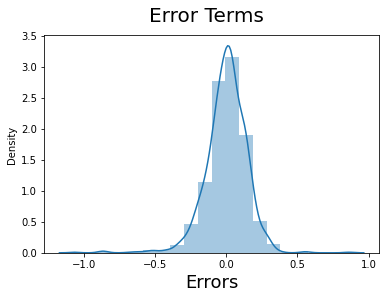

In [74]:
#plot histogram of error terms to check if assumptions of LR hold

fig = plt.figure()

sns.distplot((Y - y_pred_train), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)

From the looks of it, the error terms follow a normal distribution with mean centered around 0 which satisfies one of the assumptions of linear regression.

-----------------------------------------------

#### Ridge and Lasso Regression

Now that we have performed Linear Regression without regularization, let's move on to use ride and lasso regression and perform hyperparameter tuning to get the optimal value of alpha for both the cases. We will use linear features for x1, x2, x3,... instead of polynomial features and perform ridge and lasso regression.

In [75]:
#ridge regression

params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}

ridge = Ridge()

# cross validation
folds = 5
model_cv = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error',  
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
model_cv.fit(X_train_rfe, Y)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [76]:
# Printing the best hyperparameter alpha
print(model_cv.best_params_)

{'alpha': 0.0001}


In [77]:
#Fitting Ridge model for alpha and printing coefficients
alpha = model_cv.best_params_['alpha']
ridge = Ridge(alpha=alpha)

ridge.fit(X_train_rfe, Y)
print(ridge.coef_)

[ 0.0822506   0.14944736 -0.10614026 -0.1024353   0.07880445  0.08938978
 -0.09926116 -0.10945548  0.08894842 -0.89037334  1.03732035  0.29953633
  0.36230702  0.47441202  0.5674992   0.68814697  0.81432057  1.00907291
 -0.26391514 -0.14063139  0.42708621 -0.28963495  0.34665398 -0.3397797
 -0.37263327 -0.21605221 -0.5254489  -0.08459051 -0.09475238]


In [78]:
#let's evaluate the ridge regression model

y_pred_train = ridge.predict(X_train_rfe)

metrics_ridge = []

r2_train_lr = r2_score(Y, y_pred_train)
print("R2 Score:", r2_train_lr)
metrics_ridge.append(r2_train_lr)

rss1_lr = np.sum(np.square(Y - y_pred_train))
print("RSS value:", rss1_lr)
metrics_ridge.append(rss1_lr)

mse_train_lr = mean_squared_error(Y, y_pred_train)
print("Mean squared error:", mse_train_lr)
metrics_ridge.append(mse_train_lr**0.5)


R2 Score: 0.8666148807800382
RSS value: 27.257150819385938
Mean squared error: 0.02121179052092291


Let's perform the same gridsearch cross validation to estimate the value of alpha with lasso as our estimator.

In [79]:
#lasso regression

lasso = Lasso()

# cross validation
model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
model_cv.fit(X_train_rfe, Y)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [80]:
# Printing the best hyperparameter alpha
print(model_cv.best_params_)

{'alpha': 0.0001}


In [81]:
alpha = model_cv.best_params_['alpha']
lasso = Lasso(alpha=alpha)        
lasso.fit(X_train_rfe, Y)

Lasso(alpha=0.0001)

In [82]:
metrics_lasso = []

y_pred_train = lasso.predict(X_train_rfe)

r2_train_lr = r2_score(Y, y_pred_train)
print("R2 Score:", r2_train_lr)
metrics_lasso.append(r2_train_lr)

rss1_lr = np.sum(np.square(Y - y_pred_train))
print("RSS value:", rss1_lr)
metrics_lasso.append(rss1_lr)

mse_train_lr = mean_squared_error(Y, y_pred_train)
print("Mean squared error:", mse_train_lr)
metrics_lasso.append(mse_train_lr**0.5)

R2 Score: 0.864872535737852
RSS value: 27.61319774480016
Mean squared error: 0.021488869840311408


Let's visualise the different metrics in the form of a tabular column.

In [83]:
# # Creating a table which contain all the metrics

lr_table = {'Metric': ['R2 Score (Train)','RSS (Train)',
                       'MSE (Train)'], 
        'Linear Regression': metrics_lr
        }

lr_metric = pd.DataFrame(lr_table ,columns = ['Metric', 'Linear Regression'] )
rg_metric = pd.Series(metrics_ridge, name = 'Ridge Regression')
ls_metric = pd.Series(metrics_lasso, name = 'Lasso Regression')
final_metric = pd.concat([lr_metric, rg_metric, ls_metric], axis = 1)

final_metric

,Metric,Linear Regression,Ridge Regression,Lasso Regression
0,R2 Score (Train),0.866615,0.866615,0.864873
1,RSS (Train),27.257151,27.257151,27.613198
2,MSE (Train),0.145643,0.145643,0.146591


Let's compare coeffecients that we have obtained from Linear, Ridge and Lasso regression.

In [84]:
betas = pd.DataFrame(index=X_train_rfe.columns)
betas.rows = X_train_rfe.columns
betas['Linear'] = lr.params
betas['Ridge'] = ridge.coef_
betas['Lasso'] = lasso.coef_
pd.set_option('display.max_rows', None)
# betas.head(60)           #beta values printed at the end of notebook for comparison

#### Changing the values of alpha
Let's change the values of alpha to twice of what was obtained during cross validation and observe how the model metrics are changing.

In [85]:
########################################################################################################
#ridge regression
alpha = 0.0001*2
ridge_new = Ridge(alpha=alpha)
ridge_new.fit(X_train_rfe, Y)

y_pred_train_ridge = ridge.predict(X_train_rfe)

metrics_ridge_new = []

r2_train_lr_ridge = r2_score(Y, y_pred_train_ridge)
print("\nR2 Score for ridge regression:", r2_train_lr_ridge)
metrics_ridge_new.append(r2_train_lr_ridge)

rss1_lr_ridge = np.sum(np.square(Y - y_pred_train_ridge))
print("RSS value for ridge regression:", rss1_lr_ridge)
metrics_ridge_new.append(rss1_lr_ridge)

mse_train_lr_ridge = mean_squared_error(Y, y_pred_train_ridge)
print("Mean squared error for ridge regression:", mse_train_lr_ridge)
metrics_ridge_new.append(mse_train_lr_ridge**0.5)

############################################################################################################
#lasso regression

alpha = 0.0001*2
lasso_new = Lasso(alpha=alpha)
lasso_new.fit(X_train_rfe, Y)

y_pred_train_lasso = lasso.predict(X_train_rfe)

metrics_lasso_new = []

r2_train_lr_lasso = r2_score(Y, y_pred_train_lasso)
print("\nR2 Score for lasso regression:", r2_train_lr_lasso)
metrics_lasso_new.append(r2_train_lr_lasso)

rss1_lr_lasso = np.sum(np.square(Y - y_pred_train_lasso))
print("RSS value for lasso regression:", rss1_lr_lasso)
metrics_lasso_new.append(rss1_lr_lasso)

mse_train_lr_lasso = mean_squared_error(Y, y_pred_train_lasso)
print("Mean squared error for lasso regression:", mse_train_lr_lasso)
metrics_lasso_new.append(mse_train_lr_lasso**0.5)

#############################################################################################################
# Creating a table which contain all the metrics

lr_table = {'Metric': ['R2 Score (Train)','RSS (Train)',
                       'MSE (Train)'], 
        'Linear Regression': metrics_lr
        }

lr_metric = pd.DataFrame(lr_table ,columns = ['Metric', 'Linear Regression'] )
rg_metric_new = pd.Series(metrics_ridge_new, name = 'Ridge with 2x alpha')
ls_metric_new = pd.Series(metrics_lasso_new, name = 'Lasso with 2x alpha')
final_metric_new = pd.concat([lr_metric, rg_metric_new, ls_metric_new], axis = 1)
# print(final_metric_new)

#############################################################################################################
#comparing coeffecients

betas_new = pd.DataFrame(index=X_train_rfe.columns)
betas_new.rows = X_train_rfe.columns
betas_new['Linear'] = lr.params
betas_new['Ridge_2xalpha'] = ridge_new.coef_
betas_new['Lasso_2xalpha'] = lasso_new.coef_
pd.set_option('display.max_rows', None)
# print(betas_new.head(60))


R2 Score for ridge regression: 0.8666148807800382
RSS value for ridge regression: 27.257150819385938
Mean squared error for ridge regression: 0.02121179052092291

R2 Score for lasso regression: 0.864872535737852
RSS value for lasso regression: 27.61319774480016
Mean squared error for lasso regression: 0.021488869840311408


In [86]:
#printing stats for alpha with default values 
final_metric

,Metric,Linear Regression,Ridge Regression,Lasso Regression
0,R2 Score (Train),0.866615,0.866615,0.864873
1,RSS (Train),27.257151,27.257151,27.613198
2,MSE (Train),0.145643,0.145643,0.146591


In [87]:
#printing stats for alpha with 2x values
final_metric_new

,Metric,Linear Regression,Ridge with 2x alpha,Lasso with 2x alpha
0,R2 Score (Train),0.866615,0.866615,0.864873
1,RSS (Train),27.257151,27.257151,27.613198
2,MSE (Train),0.145643,0.145643,0.146591


Increasing the value of alpha from 0.0001 to 0.0002 does not seem to have too much effect on the ```r2```,```RSS``` and ```MSE``` values. Let's take a look at how the coeffecients differ.

In [88]:
#printing beta values for alpha = 0.0001 and 0.0001*2
betas_new = betas_new.drop(labels='Linear', axis=1)
betas = betas.join(betas_new)
betas['Ridge_diff'] = betas['Ridge_2xalpha']-betas['Ridge']
betas['Lasso_diff'] = betas['Lasso_2xalpha']-betas['Lasso']
betas = betas[['Linear', 'Ridge', 'Ridge_2xalpha', 'Ridge_diff','Lasso', 'Lasso_2xalpha','Lasso_diff']]
betas

,Linear,Ridge,Ridge_2xalpha,Ridge_diff,Lasso,Lasso_2xalpha,Lasso_diff
TotalBsmtSF,0.082249,0.082251,0.082252,1.382673e-06,0.084226,0.085801,0.001574
GrLivArea,0.149446,0.149447,0.149449,1.276386e-06,0.151113,0.152189,0.001076
MSSubClass_2-1/2 STORY ALL AGES,-0.106143,-0.106140,-0.106137,2.969251e-06,-0.088061,-0.068946,0.019115
MSSubClass_2-STORY PUD-1946 & NEWER,-0.102438,-0.102435,-0.102433,2.223420e-06,-0.094811,-0.087865,0.006946
MSSubClass_SPLIT FOYER,0.078804,0.078804,0.078805,8.611076e-07,0.074535,0.069684,-0.004851
MSZoning_FV,0.089389,0.089390,0.089391,9.901537e-07,0.087400,0.085156,-0.002244
MSZoning_RH,-0.099264,-0.099261,-0.099258,2.963910e-06,-0.083706,-0.072699,0.011006
MSZoning_RM,-0.109455,-0.109455,-0.109456,-2.237234e-07,-0.111640,-0.114163,-0.002523
Neighborhood_Crawfor,0.088949,0.088948,0.088948,-3.453348e-07,0.084948,0.081372,-0.003575
Condition2_PosN,-0.890429,-0.890373,-0.890318,5.533374e-05,-0.811210,-0.730365,0.080845


In [92]:
#sorting dataframe
betas_sorted = betas.sort_values(by=['Lasso'], ascending=False)
betas_sorted

,Linear,Ridge,Ridge_2xalpha,Ridge_diff,Lasso,Lasso_2xalpha,Lasso_diff
OverallQual_10,1.037463,1.037320,1.037178,-1.426756e-04,0.776095,0.630553,-0.145542
OverallQual_9,1.009201,1.009073,1.008945,-1.279374e-04,0.768515,0.642886,-0.125629
OverallQual_8,0.814445,0.814321,0.814196,-1.247153e-04,0.578182,0.456509,-0.121673
OverallQual_7,0.688270,0.688147,0.688024,-1.228428e-04,0.454339,0.334481,-0.119858
OverallQual_6,0.567621,0.567499,0.567377,-1.217587e-04,0.334316,0.214738,-0.119578
OverallQual_5,0.474533,0.474412,0.474291,-1.208158e-04,0.242209,0.123260,-0.118949
RoofMatl_Membran,0.427149,0.427086,0.427023,-6.308057e-05,0.225637,0.027608,-0.198029
Heating_Wall,0.346692,0.346654,0.346616,-3.766955e-05,0.176469,0.000000,-0.176469
GrLivArea,0.149446,0.149447,0.149449,1.276386e-06,0.151113,0.152189,0.001076
OverallQual_4,0.362426,0.362307,0.362188,-1.190032e-04,0.132975,0.016649,-0.116326


This table gives us the coeffecients of all the features and difference between coeffecients for ridge and lasso regression.